Packages, setup, and helper functions

In [1]:
import os 
import time
import copy
import h5py
import glob
import scipy
import random
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from numpy.random import Generator, PCG64DXSM
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from scipy import ndimage
import math
import itertools
import torch
import torchvision as tv
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, Subset
#import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage import io, transform
import pylab as pl
from IPython import display
from copy import deepcopy
import optuna

# Using PCG64 as random generator
# Place seed [optional] for troubleshooting
rng = Generator(PCG64DXSM(seed=21))

# matplotlib general set up
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


Dataset Preprocessing

In [2]:
class FaceDataset(Dataset):
    """Emotions with Two Classes dataset."""

    def __init__(self, data, targets, classes, transform=None):
        """
        Arguments:
            data (numpy array): CIFAR10 Dataset in numpy array
            targets (numpy array): Labels for samples in data
            keep_classes (numpy array): Index of classes to keep. This array is of length 2.
            classes: Two strings with the names of classes in keep_classes.
            transform (callable, optional): Optional transforms to be applied
                on a samples. This is applied during sampling (i.e., __getitem__())
        """
        self.filter_dataset(data, targets, [0, 1])
        # self.data = data
        # self.targets = targets
        self.transform = transform
        self.classes = classes


    def __len__(self):
        """
        Get the number of samples in dataset
        """
        return self.targets.shape[1]


    def __getitem__(self, idx):
        """
        Get a sample from the dataset
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.data[idx,...]
        target = self.targets[:, idx]
        sample = {'image': image, 'target': target}
        print(type(sample['image']))
        print(type(sample['target']))
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    
    def get_classes(self):
        """
        Returns string names for classes stored in this class.
        """
        return self.classes
    
    
    def class_to_idx(self, class_str):
        """
        Returns the index of the input class name.
        """
        try:
            index = self.classes.index(class_str)
        except ValueError:
            print(f"'{class_str}' is not in the list.")
            print(f"Your options are: <<{self.classes}>>.")
        return index
    

    def show_image(self, sample_idx, cmap):
        """
        Displays image at position sample_idx and its label.
        """
        
        image = self.data[sample_idx,...]
        label = self.targets[:, sample_idx]
        pl.cla()
        pl.imshow(image, cmap=cmap)
        pl.text(image.shape[1]*0.7, image.shape[0]*0.8, str(np.squeeze(label)), c='r')
        display.clear_output(wait=True)
        display.display(pl.gcf())


    def filter_dataset(self, data, targets, keepLabels):
        """
            Generate a new list of images and binary targets from original dataset.
        """
    
        # Throw error if keepLabels is not length 2
        assert len(keepLabels) == 2

        #ensure keepLabels and targets are numpy arrays
        keepLabels = np.array(keepLabels)
        targets = np.array(targets)

        # Get indexes of desired classes samples
        mask_idx = np.where(np.isin(targets, keepLabels))[0]
        print(mask_idx)
        
        # how many samples for keep classes do we have
        m = mask_idx.size
        print(f"M is {m}")
    
        #empty list of tensors
        self.data = np.ndarray(np.concatenate(([m], data.shape[1:])))
        self.targets = np.ndarray([1, m])
        print(mask_idx.shape)
        print(type(mask_idx))
        print(f"Shapes of data and targets: {self.data.shape}/{self.targets.shape}")
        for i in range(mask_idx.size):

            # save new image
            self.data[i,...] = np.copy(data[mask_idx[i],...])

            #create correct target
            if (targets[:,mask_idx[i]] == keepLabels[0]):
                self.targets[:,i] = 0
            else:
                self.targets[:,i] = 1

In [87]:
data_path = "./data"

trans = transforms.Compose([
  transforms.Resize([64,64]),  
  transforms.Grayscale(),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(10),
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))])
batch_size = 16

In [88]:
data = tv.datasets.ImageFolder(root=data_path, transform=trans)
print(type(data))



splits = random_split(data, [0.3, 0.7])

print(len(splits[0]), len(splits[1]))
print(data.classes)
print(len(data.classes))


<class 'torchvision.datasets.folder.ImageFolder'>
94 218
['anger', 'fear', 'happiness', 'sadness', 'surprise']
5


<class 'torch.utils.data.dataset.Subset'>
<class 'tuple'>
<class 'torch.Tensor'>
<class 'int'>


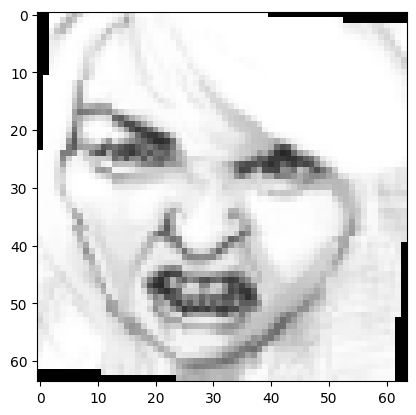

In [89]:
print(type(splits[0]))
print(type(data[0]))
print(type(data[0][0]))
print(type(data[0][1]))
# arr = np.ndarray(data[0][0])#This is your tensor
arr_ = np.squeeze(data[0][0]) # you can give axis attribute if you wanna squeeze in specific dimension
plt.imshow(arr_)
plt.show()

In [90]:
# Define a batch size
batch_size = 1

# Create iterators for dataset
train_loader = torch.utils.data.DataLoader(dataset=splits[1], shuffle=True, num_workers=0,
                                           batch_size=batch_size, drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=splits[0], shuffle=True, num_workers=0,
                                           batch_size=1, drop_last=True)
print(len(train_loader))
print(train_loader.dataset)
print(train_loader.dataset[2])
# print(train_loader.clas)


218
(tensor([[[-1.0000, -1.0000, -1.0000,  ...,  0.9922, -1.0000, -1.0000],
         [-1.0000,  0.9922,  0.9922,  ...,  0.9922,  0.9922, -1.0000],
         [ 0.9922,  0.9922,  0.9922,  ...,  0.9922,  0.9922, -1.0000],
         ...,
         [-1.0000,  0.9922,  0.9922,  ...,  0.9922,  0.9922,  0.9922],
         [-1.0000,  0.9922,  0.9922,  ...,  0.9922,  0.9922, -1.0000],
         [-1.0000, -1.0000,  0.9922,  ..., -1.0000, -1.0000, -1.0000]]]), 3)


Convolutional Network Without Dropout

In [91]:
class ConvNetWithoutDropout(nn.Module):

  # define network layers
  def __init__(self, class_len):
    super().__init__()
    # 1 input image channel, 6 output channels, 5x5 square convolution
    # kernel
    self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
    self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(4096, 128)  # 5*5 from image dimension
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, class_len)


  # define forward pass
  def forward(self, x):
    # Max pooling over a (2, 2) window
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    # If the size is a square, you can specify with a single number
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

#################################################
## Create network
model = ConvNetWithoutDropout(len(data.classes))
#Print model architecture
print(model)

ConvNetWithoutDropout(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)


In [92]:
#################################################
# Weight initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.00)


# Initialize model weights and biases
model.apply(init_weights)

/tmp/ipykernel_3111/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


ConvNetWithoutDropout(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)

In [93]:
# Functions to train and troubleshoot the model

def get_accuracy(net, data_loader):
  """It iterates over `data_loader` to calculate accuracy"""
  total_correct = 0.0
  total_samples = 0.0
  with torch.no_grad():
    for i_batch, sample_batched in enumerate(data_loader):
      # data and labels
      inputs, labels = sample_batched[0], sample_batched[1]
      
      labels = np.array(labels)
      outputs = net(inputs.float())
      predictions = np.array(torch.argmax(outputs.round(), dim=1))
      # print(labels.shape)
      # print(predictions.shape)
      # calculate the accuracy for this batch
      total_correct += (predictions == labels).astype(float).sum().item()
      total_samples += predictions.shape[0]
  # calculate the accuracy
  return total_correct / total_samples

def get_val_loss(net, criterion, data_loader):
  """It iterates over `data_loader` to calculate the overall loss"""
  testing_loss = []
  with torch.no_grad():
    for i_batch, sample_batched in enumerate(data_loader):
      # data and labels
      inputs, labels = sample_batched[0], sample_batched[1]

     # inputs, labels = inputs.to(device), labels.to(device)
      outputs = net(inputs.float())
      # calculate the loss for this batch
      loss = criterion(outputs, labels)
      # add the loss of this batch to the list
      testing_loss.append(loss.item())
  # calculate the average loss
  return sum(testing_loss) / len(testing_loss)

In [94]:
def train_model(train_loader, val_loader, model, criterion, optimizer, start_epoch=0, start_tr_loss=None, start_val_loss=None, 
                Num_Epochs=100, checkpoint_interval=50, run_name="default", save=False):
  """
  This routine receives a model architecture, a dataset with corresponding labels and other configurations for supervised training of model.

  Parameters:
    train_loader -- iterable object with data samples created using torch.utils.data.DataLoader.
    val_loader -- iterable object with validation samples created using torch.utils.data.DataLoader.
    model -- Valid Pytorch nn.Module network
    criterion -- Loss function from PyTorch nn library
    optimizer -- Optimization technique from PyTorch optim library
    Num_epochs -- Number of times to go through the train_loader samples
    start_epoch -- when resuming a previous run, this is the last epoch number performed.
    start_tr_loss -- when resuming previous run, it add the loss history to current train run
    start_val_loss -- same as with start_tr_loss but for validation set
    checkpoint_interval -- After how many epochs to save and printout network progress.
    run_name -- Prefix string used for checkpoint filename
    save -- when True it will save checkpoints 
  
  Returns:
    model -- final model with its parameters
    training_loss -- List with training loss for each epoch 
    val_loss -- List with validation loss for each epoch
  """

  if(start_tr_loss):
    training_loss, val_loss = start_tr_loss, start_val_loss
  else:
    training_loss, val_loss = [], []
  running_loss = []
  i = 0
  for epoch in range(start_epoch, Num_Epochs):
    for i_batch, sample_batched in enumerate(train_loader):

      # data and labels
      inputs, labels = sample_batched[0], sample_batched[1]

      # resets all gradients for this mini-batch
      optimizer.zero_grad()
      # forward pass
      # outputs = torch.softmax(model(inputs.float()), dim=1)
      outputs = model(inputs.float())
      # print(outputs)
      # outputs = torch.softmax(outputs, dim=1)
      # print(outputs)
      # print(f"Outputs shape are {outputs.shape}")
      # print(f"Second shape is {torch.reshape(labels.float(), outputs.shape).shape}")
      # print(f"Third shape is {labels.shape}")
      # print(labels)
      # print(outputs)
      loss = criterion(outputs, labels) # loss = criterion(outputs, torch.reshape(labels.float(), outputs.shape))

      # backward pass
      loss.backward()

      # update parameters
      optimizer.step()

      # Save current loss for plots
      running_loss.append(loss.item())
      i += 1

    #track progress
    avg_train_loss = sum(running_loss) / len(running_loss)
    avg_val_loss = get_val_loss(model, criterion, val_loader)

    # clear the list
    running_loss.clear()

    #store loss
    training_loss.append(avg_train_loss)
    val_loss.append(avg_val_loss)

    #print loss per epoch
    if((epoch+1)%checkpoint_interval==0):
      if(save):
        torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'training_loss': training_loss,
          'validation_loss': val_loss,
        }, f'{run_name}_checkpoint_{epoch+1}.pt')
      print(f"[E={epoch:2d}] [it={i:5d}] Train Loss: {avg_train_loss:.3f}, Test Loss: {avg_val_loss:.3f}")

  #return model and losses from training
  return model, training_loss, val_loss


/tmp/ipykernel_3111/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[E= 9] [it= 2070] Train Loss: 1.354, Test Loss: 1.448
[E=19] [it= 4140] Train Loss: 1.288, Test Loss: 1.577
[E=29] [it= 6210] Train Loss: 1.209, Test Loss: 1.380
[E=39] [it= 8280] Train Loss: 1.162, Test Loss: 1.394
Accuracy: Train: 0.565 | Val: 0.344


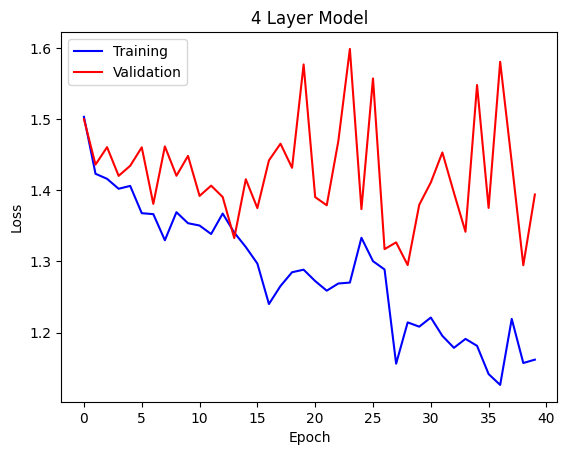

In [70]:
run_name = "sgd"
# How many epochs before saving progress
checkpoint_interval = 10
# Learning rate
learning_rate = 0.005
# L2 Normalization lambda
weight_decay = 0.01
# Momentum
momentum = 0.9
# Nesterov?
nesterov = False

# With a batch size of 64, need 198 epochs to get to 2,000 iterations
Num_Epochs = 40
# Num_Epochs = 40


#################################################
# Create network architecture
model = ConvNetWithoutDropout(len(data.classes))

# Initialize model weights
model.apply(init_weights)

## Loss, and optimizer
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, nesterov=nesterov)


#################################################
# Train model

model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model, save=False,
                                           criterion=criterion, optimizer=optimizer, Num_Epochs=Num_Epochs, checkpoint_interval=checkpoint_interval, run_name=run_name)

tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
val_acc = get_accuracy(net=model_final, data_loader=val_loader)
print(f"Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )

plt.figure()
plt.plot(trainloss, '-b')
plt.plot(valloss, '-r')
plt.ioff()
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"])
plt.title(f"4 Layer Model")
plt.show()

Regularization Testing

In [71]:
# Run name
run_name = "sgd_w_mom"

##############################################
# Hyperparameters and training configuration

# How many epochs before saving progress
checkpoint_interval = 10
# Learning rate
learning_rate = 0.0005
# L2 Normalization lambda
weight_decays = [0, 0.001, 0.01, 0.1]
# Momentum
momentum = 0.9
# Nesterov?
nesterov = False
#Number of epochs
Num_Epochs = 40


# Define layer sizes
#layer_size = [input_size, 2*input_size, input_size, input_size//2, 1]
trainlosses = []
vallosses = []
for weight_decay in weight_decays:
    #################################################
    # Create network architecture
    model = ConvNetWithoutDropout(len(data.classes))

    # Initialize model weights
    model.apply(init_weights)

    ## Loss, and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, nesterov=nesterov)


    #################################################
    # Train model
    model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model, save=False,
                                            criterion=criterion, optimizer=optimizer, Num_Epochs=Num_Epochs, checkpoint_interval=checkpoint_interval, run_name=run_name)

    # Output model performance
    tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
    val_acc = get_accuracy(net=model_final, data_loader=val_loader)
    print(f"Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )
    trainlosses.append(trainloss)
    vallosses.append(valloss)
    

/tmp/ipykernel_3111/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[E= 9] [it= 2070] Train Loss: 1.093, Test Loss: 1.314
[E=19] [it= 4140] Train Loss: 0.685, Test Loss: 1.741
[E=29] [it= 6210] Train Loss: 0.438, Test Loss: 2.429
[E=39] [it= 8280] Train Loss: 0.218, Test Loss: 3.608
Accuracy: Train: 0.889 | Val: 0.356
[E= 9] [it= 2070] Train Loss: 1.097, Test Loss: 1.350
[E=19] [it= 4140] Train Loss: 0.766, Test Loss: 1.796
[E=29] [it= 6210] Train Loss: 0.351, Test Loss: 2.266
[E=39] [it= 8280] Train Loss: 0.115, Test Loss: 2.756
Accuracy: Train: 0.981 | Val: 0.467
[E= 9] [it= 2070] Train Loss: 1.176, Test Loss: 1.376
[E=19] [it= 4140] Train Loss: 0.858, Test Loss: 1.563
[E=29] [it= 6210] Train Loss: 0.587, Test Loss: 1.623
[E=39] [it= 8280] Train Loss: 0.328, Test Loss: 2.106
Accuracy: Train: 0.899 | Val: 0.411
[E= 9] [it= 2070] Train Loss: 1.315, Test Loss: 1.372
[E=19] [it= 4140] Train Loss: 1.277, Test Loss: 1.385
[E=29] [it= 6210] Train Loss: 1.260, Test Loss: 1.400
[E=39] [it= 8280] Train Loss: 1.272, Test Loss: 1.353
Accuracy: Train: 0.386 | Val

/tmp/ipykernel_3111/1423120969.py:9: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend("Training", "Validation")


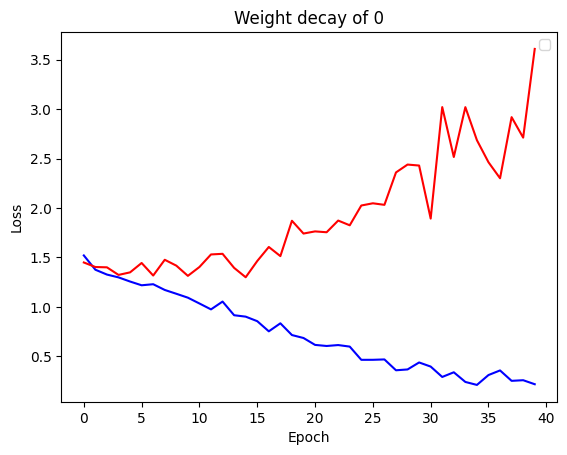

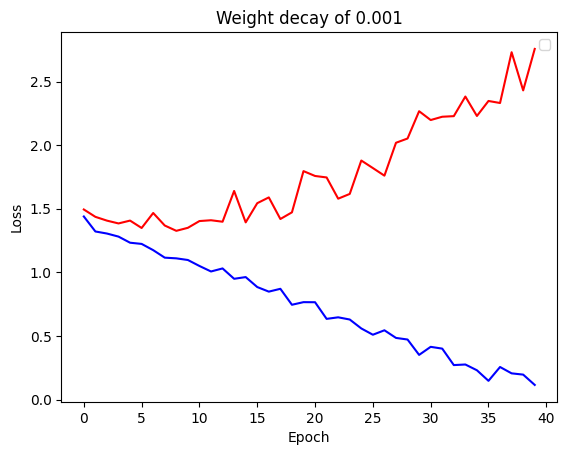

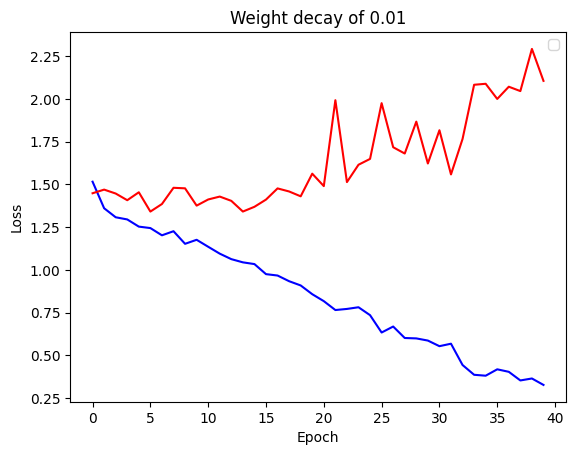

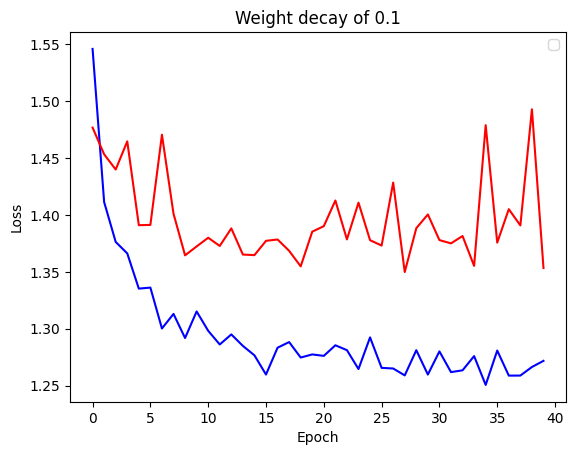

In [72]:
for trainloss, valloss, decay in zip(trainlosses, vallosses, weight_decays):
# Plot training and validation loss
    plt.figure()
    plt.plot(trainloss, '-b')
    plt.plot(valloss, '-r')
    plt.ioff()
    plt.ylabel('Loss')
    plt.xlabel("Epoch")
    plt.legend("Training", "Validation")
    plt.title(f"Weight decay of {decay}")
    plt.show()

Optimization

SGD with momentum

In [73]:
# How many epochs before saving progress
checkpoint_interval = 10
# Learning rate
learning_rate = 0.005
# L2 Normalization lambda
weight_decay = 0.01
# Momentum
momentum = 0.9
# Nesterov?
nesterov = False

# With a batch size of 64, need 198 epochs to get to 2,000 iterations
Num_Epochs = 40


#################################################
# Create network architecture
model = ConvNetWithoutDropout(len(data.classes))

# Initialize model weights
model.apply(init_weights)

## Loss, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, nesterov=nesterov)


#################################################
# Train model

model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model, save=False,
                                           criterion=criterion, optimizer=optimizer, Num_Epochs=Num_Epochs, checkpoint_interval=checkpoint_interval, run_name=run_name)

tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
val_acc = get_accuracy(net=model_final, data_loader=val_loader)
print(f"Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )

/tmp/ipykernel_3111/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[E= 9] [it= 2070] Train Loss: 1.295, Test Loss: 1.367
[E=19] [it= 4140] Train Loss: 1.173, Test Loss: 1.345
[E=29] [it= 6210] Train Loss: 1.191, Test Loss: 1.394
[E=39] [it= 8280] Train Loss: 0.983, Test Loss: 1.415
Accuracy: Train: 0.662 | Val: 0.433


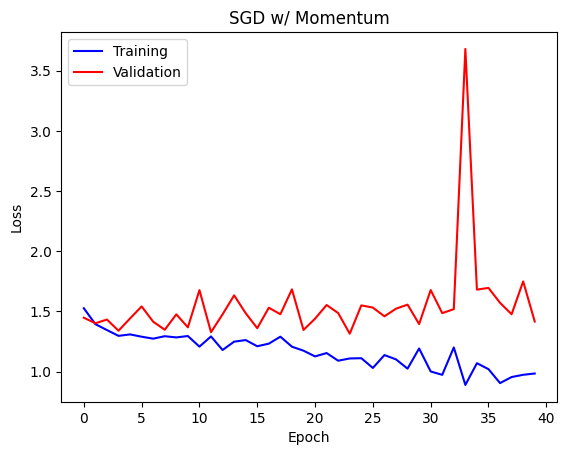

In [74]:
plt.figure()
plt.plot(trainloss, '-b')
plt.plot(valloss, '-r')
plt.ioff()
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"])
plt.title(f"SGD w/ Momentum")
plt.show()

Nesterov

In [75]:
nesterov = True

In [76]:

#################################################
# Create network architecture
model = ConvNetWithoutDropout(len(data.classes))

# Initialize model weights
model.apply(init_weights)

## Loss, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, nesterov=nesterov)


#################################################
# Train model

model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model, save=False,
                                           criterion=criterion, optimizer=optimizer, Num_Epochs=Num_Epochs, checkpoint_interval=checkpoint_interval, run_name=run_name)
tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
val_acc = get_accuracy(net=model_final, data_loader=val_loader)
print(f"Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )

/tmp/ipykernel_3111/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[E= 9] [it= 2070] Train Loss: 1.264, Test Loss: 1.399
[E=19] [it= 4140] Train Loss: 1.291, Test Loss: 1.427
[E=29] [it= 6210] Train Loss: 1.123, Test Loss: 1.479
[E=39] [it= 8280] Train Loss: 1.175, Test Loss: 1.653
Accuracy: Train: 0.522 | Val: 0.411


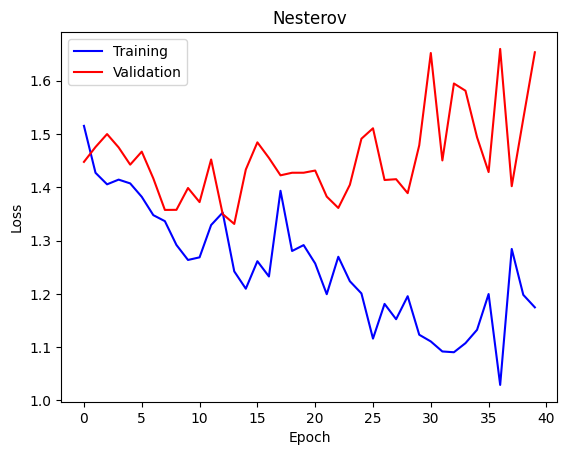

In [77]:
plt.figure()
plt.plot(trainloss, '-b')
plt.plot(valloss, '-r')
plt.ioff()
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"])
plt.title(f"Nesterov")
plt.show()

ADAM

In [78]:
betas = (0.0583756, 0.0003968)
# How many epochs before saving progress
checkpoint_interval = 10
# Learning rate
learning_rate = 0.04325696
# L2 Normalization lambda
weight_decay = 0.03090098
# Momentum
momentum = 0.9
# Nesterov?
nesterov = False

train_loader = torch.utils.data.DataLoader(dataset=splits[1], shuffle=True, num_workers=0,
                                           batch_size=2, drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=splits[0], shuffle=True, num_workers=0,
                                           batch_size=1, drop_last=True)

In [79]:

#################################################
# Create network architecture
model = ConvNetWithoutDropout(len(data.classes))

# Initialize model weights
model.apply(init_weights)

## Loss, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=betas)


#################################################
# Train model

model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model, save=False,
                                           criterion=criterion, optimizer=optimizer, Num_Epochs=Num_Epochs, checkpoint_interval=checkpoint_interval, run_name=run_name)
tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
val_acc = get_accuracy(net=model_final, data_loader=val_loader)
print(f"Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )

/tmp/ipykernel_3111/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[E= 9] [it= 1030] Train Loss: 12.746, Test Loss: 4.618
[E=19] [it= 2060] Train Loss: 11.254, Test Loss: 1.620
[E=29] [it= 3090] Train Loss: 4.797, Test Loss: 1.599
[E=39] [it= 4120] Train Loss: 12.233, Test Loss: 4.675
Accuracy: Train: 0.379 | Val: 0.356


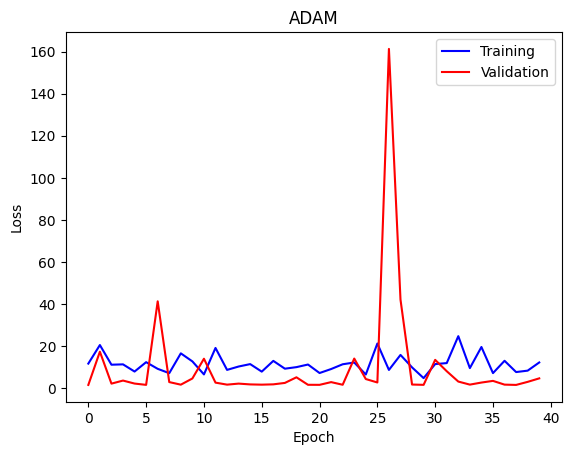

In [80]:
plt.figure()
plt.plot(trainloss, '-b')
plt.plot(valloss, '-r')
plt.ioff()
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"])
plt.title(f"ADAM")
plt.show()

NADAM

In [81]:

#################################################
# Create network architecture
model = ConvNetWithoutDropout(len(data.classes))

# Initialize model weights
model.apply(init_weights)

## Loss, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=betas)


#################################################
# Train model

model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model, save=False,
                                           criterion=criterion, optimizer=optimizer, Num_Epochs=Num_Epochs, checkpoint_interval=checkpoint_interval, run_name=run_name)
tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
val_acc = get_accuracy(net=model_final, data_loader=val_loader)
print(f"Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )

/tmp/ipykernel_3111/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[E= 9] [it= 1030] Train Loss: 5.144, Test Loss: 5.451
[E=19] [it= 2060] Train Loss: 6.662, Test Loss: 1.987
[E=29] [it= 3090] Train Loss: 4.659, Test Loss: 79.020
[E=39] [it= 4120] Train Loss: 6.331, Test Loss: 1.629
Accuracy: Train: 0.374 | Val: 0.356


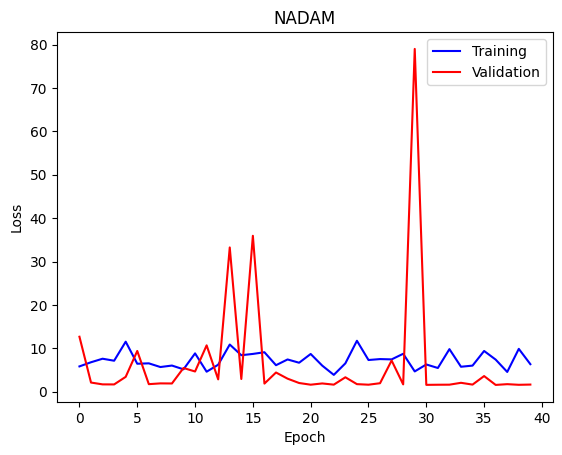

In [82]:
plt.figure()
plt.plot(trainloss, '-b')
plt.plot(valloss, '-r')
plt.ioff()
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"])
plt.title(f"NADAM")
plt.show()

Convolutional Nettwork with Dropout Masks

In [83]:
class ConvNetWithDropout(nn.Module):

  # define network layers
  def __init__(self, data_len):
    super().__init__()
    # 1 input image channel, 6 output channels, 5x5 square convolution
    # kernel
    self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
    self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(4096, 128)  # 5*5 from image dimension
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, data_len)

    self.dc2 = nn.Dropout(0.5)
    self.dc3 = nn.Dropout(0.5)


  # define forward pass
  def forward(self, x):
    # Max pooling over a (2, 2) window
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    # If the size is a square, you can specify with a single number
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
    x = self.dc2(F.relu(self.fc1(x)))
    x = self.dc3(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x

#################################################
## Create network
model = ConvNetWithoutDropout(len(data.classes))
#Print model architecture
print(model)

ConvNetWithoutDropout(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=6, bias=True)
)


/tmp/ipykernel_3111/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[E= 9] [it= 1030] Train Loss: 1.319, Test Loss: 1.470
[E=19] [it= 2060] Train Loss: 1.401, Test Loss: 1.445
[E=29] [it= 3090] Train Loss: 1.395, Test Loss: 1.430
[E=39] [it= 4120] Train Loss: 1.408, Test Loss: 1.448
Accuracy: Train: 0.354 | Val: 0.356


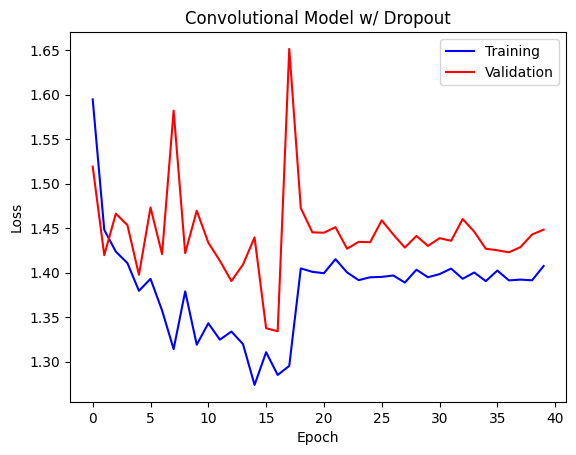

In [84]:
run_name = "sgd"
# How many epochs before saving progress
checkpoint_interval = 10
# Learning rate
learning_rate = 0.005
# L2 Normalization lambda
weight_decay = 0.01
# Momentum
momentum = 0.9
# Nesterov?
nesterov = False

# With a batch size of 64, need 198 epochs to get to 2,000 iterations
Num_Epochs = 40


#################################################
# Create network architecture
model = ConvNetWithDropout(len(data.classes))

# Initialize model weights
model.apply(init_weights)

## Loss, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, nesterov=nesterov)


#################################################
# Train model

model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model, save=False,
                                           criterion=criterion, optimizer=optimizer, Num_Epochs=Num_Epochs, checkpoint_interval=checkpoint_interval, run_name=run_name)

tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
val_acc = get_accuracy(net=model_final, data_loader=val_loader)
print(f"Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )

plt.figure()
plt.plot(trainloss, '-b')
plt.plot(valloss, '-r')
plt.ioff()
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"])
plt.title(f"Convolutional Model w/ Dropout")
plt.show()

In [85]:
def objective_SGD(trial):

    # Trial configuration
    # Name for run
    run_name = "Optuna-Test"
    # How many epochs before saving progress
    checkpoint_interval = 10
    #Number of epochs
    Num_Epochs = 20
    ## Loss
    criterion = nn.CrossEntropyLoss()

    ##############################################
    # Hyperparameters search spaces
    # Learning rate
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    # L2 Normalization lambda
    weight_decay = trial.suggest_float("L2", 1e-5, 1e-1, log=True)
    # Batch size
    batch_size = trial.suggest_categorical("batch_size", [1, 2, 4, 8])
    momentum = 0.9
    nesterov = trial.suggest_categorical("nesterov", [True, False])
    

    #################################################
    # Generate data loader based on new batch size
    train_loader = torch.utils.data.DataLoader(dataset=splits[1], shuffle=True, num_workers=0,
                                           batch_size=batch_size, drop_last=True)
    val_loader = torch.utils.data.DataLoader(dataset=splits[0], shuffle=True, num_workers=0,
                                           batch_size=1, drop_last=True)

    #################################################
    # Create network architecture

    model = ConvNetWithoutDropout(len(data.classes))

    # Initialize model weights
    model.apply(init_weights)

    ## Optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=nesterov)
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=adam_betas)

    
    #################################################
    # Train model
    model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model,
                                            criterion=criterion, optimizer=optimizer, Num_Epochs=Num_Epochs, checkpoint_interval=checkpoint_interval, run_name=run_name)

    # Output model performance
    #tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
    
    tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
    val_acc = get_accuracy(net=model_final, data_loader=val_loader)
    print(f"Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )
    if(val_acc > 0.7):
        torch.save(model, "networks/SGD/net_" + str(trial.number))
    
    # The objective function needs to return the metric to minimize or maximize
    return val_acc

study = optuna.create_study(direction="maximize", study_name="SGD-Binary-Art")
study.optimize(objective_SGD, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-05-05 17:33:02,399] A new study created in memory with name: SGD-Binary-Art
/tmp/ipykernel_3111/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[E= 9] [it= 2070] Train Loss: 1.233, Test Loss: 1.351
[E=19] [it= 4140] Train Loss: 1.142, Test Loss: 1.291


[I 2024-05-05 17:34:13,046] Trial 0 finished with value: 0.43333333333333335 and parameters: {'lr': 5.454215249453866e-05, 'L2': 8.357654902965982e-05, 'batch_size': 1, 'nesterov': True}. Best is trial 0 with value: 0.43333333333333335.


Accuracy: Train: 0.469 | Val: 0.433
[E= 9] [it=  510] Train Loss: 1.192, Test Loss: 1.548
[E=19] [it= 1020] Train Loss: 0.907, Test Loss: 1.526


[I 2024-05-05 17:35:10,126] Trial 1 finished with value: 0.4444444444444444 and parameters: {'lr': 0.0011981718758060573, 'L2': 1.3332532939287023e-05, 'batch_size': 4, 'nesterov': False}. Best is trial 1 with value: 0.4444444444444444.


Accuracy: Train: 0.623 | Val: 0.444
[E= 9] [it=  250] Train Loss: 1.241, Test Loss: 1.360
[E=19] [it=  500] Train Loss: 1.104, Test Loss: 1.397


[I 2024-05-05 17:36:02,923] Trial 2 finished with value: 0.4222222222222222 and parameters: {'lr': 0.0008982301869161233, 'L2': 0.0011830362587213973, 'batch_size': 8, 'nesterov': False}. Best is trial 1 with value: 0.4444444444444444.


Accuracy: Train: 0.465 | Val: 0.422
[E= 9] [it=  250] Train Loss: 1.207, Test Loss: 1.468
[E=19] [it=  500] Train Loss: 1.172, Test Loss: 1.377


[I 2024-05-05 17:36:56,753] Trial 3 finished with value: 0.35555555555555557 and parameters: {'lr': 0.034546881208723526, 'L2': 0.0072298853045590665, 'batch_size': 8, 'nesterov': False}. Best is trial 1 with value: 0.4444444444444444.


Accuracy: Train: 0.500 | Val: 0.356
[E= 9] [it= 2070] Train Loss: 1.197, Test Loss: 1.302
[E=19] [it= 4140] Train Loss: 0.981, Test Loss: 1.442


[I 2024-05-05 17:38:07,807] Trial 4 finished with value: 0.43333333333333335 and parameters: {'lr': 0.00029901984755149733, 'L2': 0.0017148316151448866, 'batch_size': 1, 'nesterov': True}. Best is trial 1 with value: 0.4444444444444444.


Accuracy: Train: 0.575 | Val: 0.433
[E= 9] [it=  510] Train Loss: 1.276, Test Loss: 1.397
[E=19] [it= 1020] Train Loss: 1.207, Test Loss: 1.330


[I 2024-05-05 17:39:05,151] Trial 5 finished with value: 0.3333333333333333 and parameters: {'lr': 0.0002789491493558213, 'L2': 0.047147801852236326, 'batch_size': 4, 'nesterov': True}. Best is trial 1 with value: 0.4444444444444444.


Accuracy: Train: 0.466 | Val: 0.333
[E= 9] [it= 1030] Train Loss: 1.424, Test Loss: 1.483
[E=19] [it= 2060] Train Loss: 1.406, Test Loss: 1.507


[I 2024-05-05 17:40:08,996] Trial 6 finished with value: 0.35555555555555557 and parameters: {'lr': 0.016657844516024613, 'L2': 0.019170605236957808, 'batch_size': 2, 'nesterov': False}. Best is trial 1 with value: 0.4444444444444444.


Accuracy: Train: 0.374 | Val: 0.356
[E= 9] [it=  510] Train Loss: 1.299, Test Loss: 1.397
[E=19] [it= 1020] Train Loss: 1.234, Test Loss: 1.360


[I 2024-05-05 17:41:06,687] Trial 7 finished with value: 0.37777777777777777 and parameters: {'lr': 0.0002917182222136787, 'L2': 0.01558193172154682, 'batch_size': 4, 'nesterov': True}. Best is trial 1 with value: 0.4444444444444444.


Accuracy: Train: 0.456 | Val: 0.378
[E= 9] [it=  510] Train Loss: 1.370, Test Loss: 1.460
[E=19] [it= 1020] Train Loss: 1.290, Test Loss: 1.382


[I 2024-05-05 17:42:04,212] Trial 8 finished with value: 0.4444444444444444 and parameters: {'lr': 5.1669879543377064e-05, 'L2': 0.00015165144248073048, 'batch_size': 4, 'nesterov': True}. Best is trial 1 with value: 0.4444444444444444.


Accuracy: Train: 0.431 | Val: 0.444
[E= 9] [it=  510] Train Loss: 1.517, Test Loss: 1.579
[E=19] [it= 1020] Train Loss: 1.411, Test Loss: 1.491


[I 2024-05-05 17:43:01,833] Trial 9 finished with value: 0.35555555555555557 and parameters: {'lr': 3.435083549032662e-05, 'L2': 2.883053297205321e-05, 'batch_size': 4, 'nesterov': False}. Best is trial 1 with value: 0.4444444444444444.


Accuracy: Train: 0.377 | Val: 0.356
[E= 9] [it= 1030] Train Loss: 1.110, Test Loss: 1.498
[E=19] [it= 2060] Train Loss: 0.713, Test Loss: 1.486


[I 2024-05-05 17:44:05,496] Trial 10 finished with value: 0.35555555555555557 and parameters: {'lr': 0.006040818877098795, 'L2': 1.2402473021638801e-05, 'batch_size': 2, 'nesterov': False}. Best is trial 1 with value: 0.4444444444444444.


Accuracy: Train: 0.738 | Val: 0.356
[E= 9] [it=  510] Train Loss: 1.663, Test Loss: 1.691
[E=19] [it= 1020] Train Loss: 1.543, Test Loss: 1.607


[I 2024-05-05 17:45:03,158] Trial 11 finished with value: 0.2111111111111111 and parameters: {'lr': 1.3612687779124605e-05, 'L2': 0.00013388675526179736, 'batch_size': 4, 'nesterov': True}. Best is trial 1 with value: 0.4444444444444444.


Accuracy: Train: 0.240 | Val: 0.211
[E= 9] [it=  510] Train Loss: 1.009, Test Loss: 1.363
[E=19] [it= 1020] Train Loss: 0.428, Test Loss: 2.132


[I 2024-05-05 17:46:00,643] Trial 12 finished with value: 0.4 and parameters: {'lr': 0.003039954821181471, 'L2': 0.00015820170217097069, 'batch_size': 4, 'nesterov': True}. Best is trial 1 with value: 0.4444444444444444.


Accuracy: Train: 0.824 | Val: 0.400
[E= 9] [it=  510] Train Loss: 1.136, Test Loss: 1.371
[E=19] [it= 1020] Train Loss: 0.896, Test Loss: 1.542


[I 2024-05-05 17:46:58,376] Trial 13 finished with value: 0.4222222222222222 and parameters: {'lr': 0.0016976546517262347, 'L2': 1.0042209263842857e-05, 'batch_size': 4, 'nesterov': False}. Best is trial 1 with value: 0.4444444444444444.


Accuracy: Train: 0.676 | Val: 0.422
[E= 9] [it=  510] Train Loss: 1.308, Test Loss: 1.410
[E=19] [it= 1020] Train Loss: 1.236, Test Loss: 1.357


[I 2024-05-05 17:47:57,431] Trial 14 finished with value: 0.37777777777777777 and parameters: {'lr': 0.00010311680708969589, 'L2': 0.0002963492276475983, 'batch_size': 4, 'nesterov': False}. Best is trial 1 with value: 0.4444444444444444.


Accuracy: Train: 0.426 | Val: 0.378
[E= 9] [it=  510] Train Loss: 1.416, Test Loss: 1.438
[E=19] [it= 1020] Train Loss: 1.409, Test Loss: 1.459


[I 2024-05-05 17:48:55,336] Trial 15 finished with value: 0.35555555555555557 and parameters: {'lr': 0.09611322121805227, 'L2': 3.9678419033569076e-05, 'batch_size': 4, 'nesterov': True}. Best is trial 1 with value: 0.4444444444444444.


Accuracy: Train: 0.377 | Val: 0.356
[E= 9] [it=  250] Train Loss: 1.219, Test Loss: 1.335
[E=19] [it=  500] Train Loss: 1.150, Test Loss: 1.311


[I 2024-05-05 17:49:48,375] Trial 16 finished with value: 0.3888888888888889 and parameters: {'lr': 0.0006859386276236372, 'L2': 0.000509017069676915, 'batch_size': 8, 'nesterov': False}. Best is trial 1 with value: 0.4444444444444444.


Accuracy: Train: 0.500 | Val: 0.389
[E= 9] [it= 1030] Train Loss: 1.552, Test Loss: 1.587
[E=19] [it= 2060] Train Loss: 1.396, Test Loss: 1.470


[I 2024-05-05 17:50:52,475] Trial 17 finished with value: 0.35555555555555557 and parameters: {'lr': 1.547296038962565e-05, 'L2': 3.138019064148077e-05, 'batch_size': 2, 'nesterov': True}. Best is trial 1 with value: 0.4444444444444444.


Accuracy: Train: 0.379 | Val: 0.356
[E= 9] [it= 2070] Train Loss: 1.288, Test Loss: 1.548
[E=19] [it= 4140] Train Loss: 1.272, Test Loss: 1.582


[I 2024-05-05 17:52:03,498] Trial 18 finished with value: 0.32222222222222224 and parameters: {'lr': 0.006973959087241461, 'L2': 0.002288729272803842, 'batch_size': 1, 'nesterov': True}. Best is trial 1 with value: 0.4444444444444444.


Accuracy: Train: 0.367 | Val: 0.322
[E= 9] [it=  510] Train Loss: 1.530, Test Loss: 1.573
[E=19] [it= 1020] Train Loss: 1.369, Test Loss: 1.428


[I 2024-05-05 17:53:02,015] Trial 19 finished with value: 0.25555555555555554 and parameters: {'lr': 4.750933172097923e-05, 'L2': 6.947643991366285e-05, 'batch_size': 4, 'nesterov': False}. Best is trial 1 with value: 0.4444444444444444.


Accuracy: Train: 0.338 | Val: 0.256
[E= 9] [it=  510] Train Loss: 1.289, Test Loss: 1.405
[E=19] [it= 1020] Train Loss: 1.227, Test Loss: 1.366


[I 2024-05-05 17:53:59,922] Trial 20 finished with value: 0.4777777777777778 and parameters: {'lr': 0.00011830023031143946, 'L2': 0.00039111741507697617, 'batch_size': 4, 'nesterov': True}. Best is trial 20 with value: 0.4777777777777778.


Accuracy: Train: 0.422 | Val: 0.478
[E= 9] [it=  510] Train Loss: 1.280, Test Loss: 1.407
[E=19] [it= 1020] Train Loss: 1.213, Test Loss: 1.392


[I 2024-05-05 17:54:57,695] Trial 21 finished with value: 0.4 and parameters: {'lr': 0.00012521436134281568, 'L2': 0.00046332094652905937, 'batch_size': 4, 'nesterov': True}. Best is trial 20 with value: 0.4777777777777778.


Accuracy: Train: 0.441 | Val: 0.400
[E= 9] [it=  510] Train Loss: 1.275, Test Loss: 1.415
[E=19] [it= 1020] Train Loss: 1.174, Test Loss: 1.375


[I 2024-05-05 17:55:55,591] Trial 22 finished with value: 0.3888888888888889 and parameters: {'lr': 0.00017716653827808606, 'L2': 0.004162248798121162, 'batch_size': 4, 'nesterov': True}. Best is trial 20 with value: 0.4777777777777778.


Accuracy: Train: 0.495 | Val: 0.389
[E= 9] [it=  510] Train Loss: 1.160, Test Loss: 1.465
[E=19] [it= 1020] Train Loss: 0.967, Test Loss: 1.419


[I 2024-05-05 17:56:53,310] Trial 23 finished with value: 0.4222222222222222 and parameters: {'lr': 0.0006484795167067853, 'L2': 0.00028030790614986173, 'batch_size': 4, 'nesterov': True}. Best is trial 20 with value: 0.4777777777777778.


Accuracy: Train: 0.706 | Val: 0.422
[E= 9] [it=  510] Train Loss: 1.481, Test Loss: 1.504
[E=19] [it= 1020] Train Loss: 1.368, Test Loss: 1.438


[I 2024-05-05 17:57:50,973] Trial 24 finished with value: 0.36666666666666664 and parameters: {'lr': 3.2674469276497774e-05, 'L2': 2.1157846628660872e-05, 'batch_size': 4, 'nesterov': True}. Best is trial 20 with value: 0.4777777777777778.


Accuracy: Train: 0.368 | Val: 0.367
[E= 9] [it=  510] Train Loss: 1.137, Test Loss: 1.349
[E=19] [it= 1020] Train Loss: 0.691, Test Loss: 1.636


[I 2024-05-05 17:58:48,878] Trial 25 finished with value: 0.4777777777777778 and parameters: {'lr': 0.001993987362750642, 'L2': 0.0008204570222854077, 'batch_size': 4, 'nesterov': True}. Best is trial 20 with value: 0.4777777777777778.


Accuracy: Train: 0.750 | Val: 0.478
[E= 9] [it=  250] Train Loss: 1.168, Test Loss: 1.409
[E=19] [it=  500] Train Loss: 0.862, Test Loss: 1.769


[I 2024-05-05 17:59:41,978] Trial 26 finished with value: 0.4444444444444444 and parameters: {'lr': 0.0030341335118176413, 'L2': 0.0007938594183036543, 'batch_size': 8, 'nesterov': False}. Best is trial 20 with value: 0.4777777777777778.


Accuracy: Train: 0.605 | Val: 0.444
[E= 9] [it= 2070] Train Loss: 1.057, Test Loss: 1.540
[E=19] [it= 4140] Train Loss: 0.715, Test Loss: 1.676


[I 2024-05-05 18:00:53,610] Trial 27 finished with value: 0.4222222222222222 and parameters: {'lr': 0.0019611377882604235, 'L2': 0.003616568314946156, 'batch_size': 1, 'nesterov': True}. Best is trial 20 with value: 0.4777777777777778.


Accuracy: Train: 0.700 | Val: 0.422
[E= 9] [it= 1030] Train Loss: 1.230, Test Loss: 1.360
[E=19] [it= 2060] Train Loss: 1.157, Test Loss: 1.365


[I 2024-05-05 18:01:58,137] Trial 28 finished with value: 0.4444444444444444 and parameters: {'lr': 0.0004836749891509752, 'L2': 0.07973184595491628, 'batch_size': 2, 'nesterov': False}. Best is trial 20 with value: 0.4777777777777778.


Accuracy: Train: 0.451 | Val: 0.444
[E= 9] [it= 2070] Train Loss: 1.401, Test Loss: 1.421
[E=19] [it= 4140] Train Loss: 1.391, Test Loss: 1.430


[I 2024-05-05 18:03:09,533] Trial 29 finished with value: 0.35555555555555557 and parameters: {'lr': 0.008887452836062947, 'L2': 6.49934131786811e-05, 'batch_size': 1, 'nesterov': True}. Best is trial 20 with value: 0.4777777777777778.


Accuracy: Train: 0.377 | Val: 0.356
[E= 9] [it=  510] Train Loss: 1.190, Test Loss: 1.428
[E=19] [it= 1020] Train Loss: 0.925, Test Loss: 1.445


[I 2024-05-05 18:04:07,634] Trial 30 finished with value: 0.45555555555555555 and parameters: {'lr': 0.001314397287007079, 'L2': 0.000795717090047066, 'batch_size': 4, 'nesterov': True}. Best is trial 20 with value: 0.4777777777777778.


Accuracy: Train: 0.598 | Val: 0.456
[E= 9] [it=  510] Train Loss: 1.051, Test Loss: 1.347
[E=19] [it= 1020] Train Loss: 0.654, Test Loss: 1.931


[I 2024-05-05 18:05:04,911] Trial 31 finished with value: 0.37777777777777777 and parameters: {'lr': 0.002842636370409724, 'L2': 0.0007564807709110293, 'batch_size': 4, 'nesterov': True}. Best is trial 20 with value: 0.4777777777777778.


Accuracy: Train: 0.740 | Val: 0.378
[E= 9] [it=  510] Train Loss: 1.124, Test Loss: 1.458
[E=19] [it= 1020] Train Loss: 0.846, Test Loss: 1.593


[I 2024-05-05 18:06:02,569] Trial 32 finished with value: 0.43333333333333335 and parameters: {'lr': 0.0012546001804950213, 'L2': 0.001459000371011054, 'batch_size': 4, 'nesterov': True}. Best is trial 20 with value: 0.4777777777777778.


Accuracy: Train: 0.676 | Val: 0.433
[E= 9] [it=  510] Train Loss: 1.181, Test Loss: 1.351
[E=19] [it= 1020] Train Loss: 0.930, Test Loss: 1.473


[I 2024-05-05 18:07:00,232] Trial 33 finished with value: 0.4888888888888889 and parameters: {'lr': 0.0010594596585298975, 'L2': 0.00027906132902396524, 'batch_size': 4, 'nesterov': True}. Best is trial 33 with value: 0.4888888888888889.


Accuracy: Train: 0.544 | Val: 0.489
[E= 9] [it=  510] Train Loss: 1.198, Test Loss: 1.313
[E=19] [it= 1020] Train Loss: 0.999, Test Loss: 1.321


[I 2024-05-05 18:07:57,827] Trial 34 finished with value: 0.43333333333333335 and parameters: {'lr': 0.0004498047991381692, 'L2': 0.00027749998512996643, 'batch_size': 4, 'nesterov': True}. Best is trial 33 with value: 0.4888888888888889.


Accuracy: Train: 0.608 | Val: 0.433
[E= 9] [it=  250] Train Loss: 1.281, Test Loss: 1.337
[E=19] [it=  500] Train Loss: 1.119, Test Loss: 1.304


[I 2024-05-05 18:08:50,726] Trial 35 finished with value: 0.4222222222222222 and parameters: {'lr': 0.0010892176006742707, 'L2': 0.0005083354066303829, 'batch_size': 8, 'nesterov': True}. Best is trial 33 with value: 0.4888888888888889.


Accuracy: Train: 0.500 | Val: 0.422
[E= 9] [it=  510] Train Loss: 1.147, Test Loss: 1.327
[E=19] [it= 1020] Train Loss: 0.706, Test Loss: 1.531


[I 2024-05-05 18:09:47,655] Trial 36 finished with value: 0.34444444444444444 and parameters: {'lr': 0.004791963317812742, 'L2': 0.0010711541446421175, 'batch_size': 4, 'nesterov': True}. Best is trial 33 with value: 0.4888888888888889.


Accuracy: Train: 0.760 | Val: 0.344
[E= 9] [it=  510] Train Loss: 1.079, Test Loss: 1.528
[E=19] [it= 1020] Train Loss: 0.901, Test Loss: 1.566


[I 2024-05-05 18:10:43,956] Trial 37 finished with value: 0.34444444444444444 and parameters: {'lr': 0.011637196084047294, 'L2': 0.002563544519615686, 'batch_size': 4, 'nesterov': True}. Best is trial 33 with value: 0.4888888888888889.


Accuracy: Train: 0.627 | Val: 0.344
[E= 9] [it= 2070] Train Loss: 1.175, Test Loss: 1.384
[E=19] [it= 4140] Train Loss: 1.026, Test Loss: 1.448


[I 2024-05-05 18:11:53,225] Trial 38 finished with value: 0.4444444444444444 and parameters: {'lr': 0.00017463116875406122, 'L2': 0.008096272263725635, 'batch_size': 1, 'nesterov': True}. Best is trial 33 with value: 0.4888888888888889.


Accuracy: Train: 0.527 | Val: 0.444
[E= 9] [it=  510] Train Loss: 1.393, Test Loss: 1.431
[E=19] [it= 1020] Train Loss: 1.395, Test Loss: 1.463


[I 2024-05-05 18:12:49,384] Trial 39 finished with value: 0.35555555555555557 and parameters: {'lr': 0.02935322310634825, 'L2': 0.0003939931693143584, 'batch_size': 4, 'nesterov': True}. Best is trial 33 with value: 0.4888888888888889.


Accuracy: Train: 0.382 | Val: 0.356
[E= 9] [it=  250] Train Loss: 1.222, Test Loss: 1.332
[E=19] [it=  500] Train Loss: 1.008, Test Loss: 1.358


[I 2024-05-05 18:13:41,898] Trial 40 finished with value: 0.4222222222222222 and parameters: {'lr': 0.0009004024258679635, 'L2': 0.00019362222334931345, 'batch_size': 8, 'nesterov': True}. Best is trial 33 with value: 0.4888888888888889.


Accuracy: Train: 0.535 | Val: 0.422
[E= 9] [it=  510] Train Loss: 1.041, Test Loss: 1.558
[E=19] [it= 1020] Train Loss: 0.713, Test Loss: 1.471


[I 2024-05-05 18:14:38,088] Trial 41 finished with value: 0.5 and parameters: {'lr': 0.0019185987031918226, 'L2': 9.901068135370631e-05, 'batch_size': 4, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.735 | Val: 0.500
[E= 9] [it=  510] Train Loss: 1.089, Test Loss: 1.408
[E=19] [it= 1020] Train Loss: 0.659, Test Loss: 1.683


[I 2024-05-05 18:15:33,431] Trial 42 finished with value: 0.4666666666666667 and parameters: {'lr': 0.0017458751889483544, 'L2': 9.300710665261129e-05, 'batch_size': 4, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.662 | Val: 0.467
[E= 9] [it=  510] Train Loss: 1.049, Test Loss: 1.676
[E=19] [it= 1020] Train Loss: 0.576, Test Loss: 2.090


[I 2024-05-05 18:16:30,537] Trial 43 finished with value: 0.4777777777777778 and parameters: {'lr': 0.004614562607134944, 'L2': 9.028993995118851e-05, 'batch_size': 4, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.789 | Val: 0.478
[E= 9] [it=  510] Train Loss: 1.279, Test Loss: 1.373
[E=19] [it= 1020] Train Loss: 0.831, Test Loss: 1.365


[I 2024-05-05 18:17:27,616] Trial 44 finished with value: 0.4 and parameters: {'lr': 0.004382109223365877, 'L2': 4.849681620915446e-05, 'batch_size': 4, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.637 | Val: 0.400
[E= 9] [it= 1030] Train Loss: 1.352, Test Loss: 1.504
[E=19] [it= 2060] Train Loss: 1.379, Test Loss: 1.414


[I 2024-05-05 18:18:31,502] Trial 45 finished with value: 0.35555555555555557 and parameters: {'lr': 0.014103185396791142, 'L2': 0.00010011548255165235, 'batch_size': 2, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.379 | Val: 0.356
[E= 9] [it=  510] Train Loss: 1.102, Test Loss: 1.362
[E=19] [it= 1020] Train Loss: 0.595, Test Loss: 1.739


[I 2024-05-05 18:19:29,688] Trial 46 finished with value: 0.43333333333333335 and parameters: {'lr': 0.0025588016162348274, 'L2': 0.0002107726382413078, 'batch_size': 4, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.784 | Val: 0.433
[E= 9] [it=  510] Train Loss: 1.207, Test Loss: 1.356
[E=19] [it= 1020] Train Loss: 1.027, Test Loss: 1.372


[I 2024-05-05 18:20:27,061] Trial 47 finished with value: 0.4111111111111111 and parameters: {'lr': 0.0003900697863826583, 'L2': 0.00011228163116136231, 'batch_size': 4, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.500 | Val: 0.411
[E= 9] [it=  510] Train Loss: 1.265, Test Loss: 1.459
[E=19] [it= 1020] Train Loss: 1.073, Test Loss: 1.501


[I 2024-05-05 18:21:24,721] Trial 48 finished with value: 0.43333333333333335 and parameters: {'lr': 0.02120644002781443, 'L2': 5.5792276806867565e-05, 'batch_size': 4, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.632 | Val: 0.433
[E= 9] [it=  510] Train Loss: 1.041, Test Loss: 1.482
[E=19] [it= 1020] Train Loss: 0.548, Test Loss: 1.667


[I 2024-05-05 18:22:22,711] Trial 49 finished with value: 0.45555555555555555 and parameters: {'lr': 0.004131502455786573, 'L2': 1.9858868557713828e-05, 'batch_size': 4, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.873 | Val: 0.456
[E= 9] [it= 1030] Train Loss: 1.174, Test Loss: 1.338
[E=19] [it= 2060] Train Loss: 0.893, Test Loss: 1.605


[I 2024-05-05 18:23:26,900] Trial 50 finished with value: 0.45555555555555555 and parameters: {'lr': 0.0007440988799460238, 'L2': 0.00019298801160217707, 'batch_size': 2, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.607 | Val: 0.456
[E= 9] [it=  510] Train Loss: 1.253, Test Loss: 1.393
[E=19] [it= 1020] Train Loss: 0.934, Test Loss: 1.664


[I 2024-05-05 18:24:24,326] Trial 51 finished with value: 0.3333333333333333 and parameters: {'lr': 0.001907674286857019, 'L2': 8.794360815111499e-05, 'batch_size': 4, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.480 | Val: 0.333
[E= 9] [it=  510] Train Loss: 1.092, Test Loss: 1.357
[E=19] [it= 1020] Train Loss: 0.961, Test Loss: 1.444


[I 2024-05-05 18:25:21,470] Trial 52 finished with value: 0.35555555555555557 and parameters: {'lr': 0.0015787072452223979, 'L2': 0.00013117878903943142, 'batch_size': 4, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.662 | Val: 0.356
[E= 9] [it=  510] Train Loss: 1.159, Test Loss: 1.327
[E=19] [it= 1020] Train Loss: 0.861, Test Loss: 1.513


[I 2024-05-05 18:26:18,832] Trial 53 finished with value: 0.34444444444444444 and parameters: {'lr': 0.006706260523675069, 'L2': 0.00032536851597211386, 'batch_size': 4, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.647 | Val: 0.344
[E= 9] [it=  510] Train Loss: 1.144, Test Loss: 1.500
[E=19] [it= 1020] Train Loss: 0.911, Test Loss: 1.620


[I 2024-05-05 18:27:16,313] Trial 54 finished with value: 0.4444444444444444 and parameters: {'lr': 0.002117888413394298, 'L2': 8.587101121492475e-05, 'batch_size': 4, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.701 | Val: 0.444
[E= 9] [it=  510] Train Loss: 1.055, Test Loss: 1.324
[E=19] [it= 1020] Train Loss: 0.631, Test Loss: 1.839


[I 2024-05-05 18:28:13,946] Trial 55 finished with value: 0.36666666666666664 and parameters: {'lr': 0.0036641757716687623, 'L2': 0.0005668427970965998, 'batch_size': 4, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.824 | Val: 0.367
[E= 9] [it=  510] Train Loss: 1.258, Test Loss: 1.387
[E=19] [it= 1020] Train Loss: 1.154, Test Loss: 1.422


[I 2024-05-05 18:29:11,353] Trial 56 finished with value: 0.35555555555555557 and parameters: {'lr': 0.0002687378263041062, 'L2': 0.00022657763589014606, 'batch_size': 4, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.559 | Val: 0.356
[E= 9] [it=  510] Train Loss: 1.230, Test Loss: 1.364
[E=19] [it= 1020] Train Loss: 1.076, Test Loss: 1.469


[I 2024-05-05 18:30:08,629] Trial 57 finished with value: 0.3888888888888889 and parameters: {'lr': 0.0006054691641397612, 'L2': 0.00013399553210462025, 'batch_size': 4, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.554 | Val: 0.389
[E= 9] [it=  250] Train Loss: 1.221, Test Loss: 1.370
[E=19] [it=  500] Train Loss: 1.068, Test Loss: 1.296


[I 2024-05-05 18:31:01,708] Trial 58 finished with value: 0.4888888888888889 and parameters: {'lr': 0.0010185215716841888, 'L2': 3.703730566591527e-05, 'batch_size': 8, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.515 | Val: 0.489
[E= 9] [it=  250] Train Loss: 1.385, Test Loss: 1.449
[E=19] [it=  500] Train Loss: 1.396, Test Loss: 1.416


[I 2024-05-05 18:31:54,524] Trial 59 finished with value: 0.35555555555555557 and parameters: {'lr': 0.06644745406821555, 'L2': 4.114780886736092e-05, 'batch_size': 8, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.370 | Val: 0.356
[E= 9] [it=  250] Train Loss: 1.210, Test Loss: 1.372
[E=19] [it=  500] Train Loss: 1.062, Test Loss: 1.379


[I 2024-05-05 18:32:46,882] Trial 60 finished with value: 0.3888888888888889 and parameters: {'lr': 0.0008332797116784172, 'L2': 2.511678445802412e-05, 'batch_size': 8, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.480 | Val: 0.389
[E= 9] [it=  250] Train Loss: 1.213, Test Loss: 1.359
[E=19] [it=  500] Train Loss: 1.010, Test Loss: 1.333


[I 2024-05-05 18:33:39,645] Trial 61 finished with value: 0.43333333333333335 and parameters: {'lr': 0.0013410163120339976, 'L2': 6.90551346832462e-05, 'batch_size': 8, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.550 | Val: 0.433
[E= 9] [it=  250] Train Loss: 1.135, Test Loss: 1.358
[E=19] [it=  500] Train Loss: 0.850, Test Loss: 1.654


[I 2024-05-05 18:34:32,079] Trial 62 finished with value: 0.36666666666666664 and parameters: {'lr': 0.0023574406545146588, 'L2': 3.9911768412181776e-05, 'batch_size': 8, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.750 | Val: 0.367
[E= 9] [it= 2070] Train Loss: 1.225, Test Loss: 1.371
[E=19] [it= 4140] Train Loss: 1.388, Test Loss: 1.464


[I 2024-05-05 18:35:42,894] Trial 63 finished with value: 0.35555555555555557 and parameters: {'lr': 0.008857196027630751, 'L2': 1.8123053319272943e-05, 'batch_size': 1, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.377 | Val: 0.356
[E= 9] [it=  510] Train Loss: 1.076, Test Loss: 1.475
[E=19] [it= 1020] Train Loss: 0.830, Test Loss: 1.500


[I 2024-05-05 18:36:40,013] Trial 64 finished with value: 0.4666666666666667 and parameters: {'lr': 0.0009878457409788338, 'L2': 0.00015466720868329866, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.672 | Val: 0.467
[E= 9] [it=  510] Train Loss: 1.213, Test Loss: 1.336
[E=19] [it= 1020] Train Loss: 0.816, Test Loss: 1.385


[I 2024-05-05 18:37:37,472] Trial 65 finished with value: 0.45555555555555555 and parameters: {'lr': 0.005696987534645963, 'L2': 0.0006943191913386215, 'batch_size': 4, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.716 | Val: 0.456
[E= 9] [it=  250] Train Loss: 1.109, Test Loss: 1.335
[E=19] [it=  500] Train Loss: 0.767, Test Loss: 1.518


[I 2024-05-05 18:38:30,954] Trial 66 finished with value: 0.4222222222222222 and parameters: {'lr': 0.001658714379248058, 'L2': 3.318963982205901e-05, 'batch_size': 8, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.710 | Val: 0.422
[E= 9] [it=  510] Train Loss: 1.304, Test Loss: 1.435
[E=19] [it= 1020] Train Loss: 1.241, Test Loss: 1.385


[I 2024-05-05 18:39:28,192] Trial 67 finished with value: 0.36666666666666664 and parameters: {'lr': 8.260726617941224e-05, 'L2': 0.0014372758943264545, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.392 | Val: 0.367
[E= 9] [it= 1030] Train Loss: 1.247, Test Loss: 1.384
[E=19] [it= 2060] Train Loss: 1.043, Test Loss: 1.422


[I 2024-05-05 18:40:32,087] Trial 68 finished with value: 0.4666666666666667 and parameters: {'lr': 0.00033443699910617997, 'L2': 0.0003803457042920595, 'batch_size': 2, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.539 | Val: 0.467
[E= 9] [it=  510] Train Loss: 1.205, Test Loss: 1.475
[E=19] [it= 1020] Train Loss: 0.969, Test Loss: 1.516


[I 2024-05-05 18:41:29,322] Trial 69 finished with value: 0.37777777777777777 and parameters: {'lr': 0.0005678176200576054, 'L2': 1.2252852927599668e-05, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.608 | Val: 0.378
[E= 9] [it=  510] Train Loss: 0.967, Test Loss: 1.632
[E=19] [it= 1020] Train Loss: 0.495, Test Loss: 1.617


[I 2024-05-05 18:42:26,950] Trial 70 finished with value: 0.5 and parameters: {'lr': 0.0031947665133633444, 'L2': 5.359990690990662e-05, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.833 | Val: 0.500
[E= 9] [it=  510] Train Loss: 1.101, Test Loss: 1.332
[E=19] [it= 1020] Train Loss: 0.700, Test Loss: 1.446


[I 2024-05-05 18:43:24,186] Trial 71 finished with value: 0.45555555555555555 and parameters: {'lr': 0.0031682154828382406, 'L2': 7.558145105896436e-05, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.809 | Val: 0.456
[E= 9] [it=  510] Train Loss: 0.959, Test Loss: 1.549
[E=19] [it= 1020] Train Loss: 0.607, Test Loss: 1.756


[I 2024-05-05 18:44:21,016] Trial 72 finished with value: 0.4777777777777778 and parameters: {'lr': 0.002295066878980944, 'L2': 5.9440074371823214e-05, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.775 | Val: 0.478
[E= 9] [it=  510] Train Loss: 1.049, Test Loss: 1.287
[E=19] [it= 1020] Train Loss: 0.545, Test Loss: 2.282


[I 2024-05-05 18:45:18,404] Trial 73 finished with value: 0.4222222222222222 and parameters: {'lr': 0.0034416518270203975, 'L2': 5.628857369482917e-05, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.735 | Val: 0.422
[E= 9] [it=  510] Train Loss: 1.112, Test Loss: 1.332
[E=19] [it= 1020] Train Loss: 0.827, Test Loss: 1.607


[I 2024-05-05 18:46:15,608] Trial 74 finished with value: 0.4444444444444444 and parameters: {'lr': 0.0013321022018992692, 'L2': 2.6389483066023974e-05, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.672 | Val: 0.444
[E= 9] [it=  510] Train Loss: 1.082, Test Loss: 1.333
[E=19] [it= 1020] Train Loss: 0.612, Test Loss: 1.914


[I 2024-05-05 18:47:12,882] Trial 75 finished with value: 0.4111111111111111 and parameters: {'lr': 0.004749817612211552, 'L2': 4.427243551428182e-05, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.804 | Val: 0.411
[E= 9] [it=  250] Train Loss: 1.122, Test Loss: 1.431
[E=19] [it=  500] Train Loss: 0.815, Test Loss: 1.494


[I 2024-05-05 18:48:05,318] Trial 76 finished with value: 0.43333333333333335 and parameters: {'lr': 0.0023909695965611483, 'L2': 0.0002516685235242735, 'batch_size': 8, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.745 | Val: 0.433
[E= 9] [it= 2070] Train Loss: 1.024, Test Loss: 1.374
[E=19] [it= 4140] Train Loss: 0.641, Test Loss: 2.344


[I 2024-05-05 18:49:16,123] Trial 77 finished with value: 0.3333333333333333 and parameters: {'lr': 0.0011091729903771781, 'L2': 0.00011075650605776372, 'batch_size': 1, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.715 | Val: 0.333
[E= 9] [it=  510] Train Loss: 1.472, Test Loss: 1.550
[E=19] [it= 1020] Train Loss: 1.376, Test Loss: 1.480


[I 2024-05-05 18:50:13,506] Trial 78 finished with value: 0.35555555555555557 and parameters: {'lr': 2.2143277671654253e-05, 'L2': 1.5644848811952377e-05, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.382 | Val: 0.356
[E= 9] [it=  510] Train Loss: 0.928, Test Loss: 1.323
[E=19] [it= 1020] Train Loss: 0.610, Test Loss: 1.886


[I 2024-05-05 18:51:10,801] Trial 79 finished with value: 0.37777777777777777 and parameters: {'lr': 0.009264697276357554, 'L2': 0.00018208669213780522, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.686 | Val: 0.378
[E= 9] [it=  510] Train Loss: 1.266, Test Loss: 1.375
[E=19] [it= 1020] Train Loss: 1.193, Test Loss: 1.353


[I 2024-05-05 18:52:08,162] Trial 80 finished with value: 0.4444444444444444 and parameters: {'lr': 0.00022011761245244873, 'L2': 5.460496222255105e-05, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.446 | Val: 0.444
[E= 9] [it=  510] Train Loss: 1.088, Test Loss: 1.438
[E=19] [it= 1020] Train Loss: 0.805, Test Loss: 1.517


[I 2024-05-05 18:53:05,553] Trial 81 finished with value: 0.4666666666666667 and parameters: {'lr': 0.0015411005341586014, 'L2': 3.180206216991144e-05, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.735 | Val: 0.467
[E= 9] [it=  510] Train Loss: 1.119, Test Loss: 1.332
[E=19] [it= 1020] Train Loss: 0.741, Test Loss: 1.522


[I 2024-05-05 18:54:02,793] Trial 82 finished with value: 0.4444444444444444 and parameters: {'lr': 0.001967504136065539, 'L2': 7.85888992456147e-05, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.696 | Val: 0.444
[E= 9] [it=  510] Train Loss: 1.079, Test Loss: 1.462
[E=19] [it= 1020] Train Loss: 0.738, Test Loss: 1.872


[I 2024-05-05 18:54:59,739] Trial 83 finished with value: 0.4111111111111111 and parameters: {'lr': 0.0027115594344210457, 'L2': 0.00010501081489950546, 'batch_size': 4, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.745 | Val: 0.411
[E= 9] [it=  510] Train Loss: 1.151, Test Loss: 1.327
[E=19] [it= 1020] Train Loss: 0.913, Test Loss: 1.483


[I 2024-05-05 18:55:56,725] Trial 84 finished with value: 0.4222222222222222 and parameters: {'lr': 0.0008294572113228069, 'L2': 0.0009780633828151601, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.627 | Val: 0.422
[E= 9] [it=  510] Train Loss: 1.211, Test Loss: 1.438
[E=19] [it= 1020] Train Loss: 1.074, Test Loss: 1.483


[I 2024-05-05 18:56:53,773] Trial 85 finished with value: 0.45555555555555555 and parameters: {'lr': 0.0036772527261874025, 'L2': 0.024110647386331396, 'batch_size': 4, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.569 | Val: 0.456
[E= 9] [it= 1030] Train Loss: 1.121, Test Loss: 1.382
[E=19] [it= 2060] Train Loss: 0.878, Test Loss: 1.815


[I 2024-05-05 18:57:57,501] Trial 86 finished with value: 0.35555555555555557 and parameters: {'lr': 0.005166855254405608, 'L2': 0.0003516901731150571, 'batch_size': 2, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.680 | Val: 0.356
[E= 9] [it=  510] Train Loss: 1.197, Test Loss: 1.332
[E=19] [it= 1020] Train Loss: 1.050, Test Loss: 1.329


[I 2024-05-05 18:58:54,684] Trial 87 finished with value: 0.4444444444444444 and parameters: {'lr': 0.0004808195647236919, 'L2': 6.044273870916917e-05, 'batch_size': 4, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.593 | Val: 0.444
[E= 9] [it=  510] Train Loss: 1.159, Test Loss: 1.426
[E=19] [it= 1020] Train Loss: 0.908, Test Loss: 1.696


[I 2024-05-05 18:59:52,628] Trial 88 finished with value: 0.4222222222222222 and parameters: {'lr': 0.0010890231485381834, 'L2': 0.0006064189037319562, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.583 | Val: 0.422
[E= 9] [it= 2070] Train Loss: 1.093, Test Loss: 1.538
[E=19] [it= 4140] Train Loss: 0.813, Test Loss: 1.754


[I 2024-05-05 19:01:03,019] Trial 89 finished with value: 0.4444444444444444 and parameters: {'lr': 0.0017221785952979418, 'L2': 0.00043491092540115425, 'batch_size': 1, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.638 | Val: 0.444
[E= 9] [it=  510] Train Loss: 1.649, Test Loss: 1.675
[E=19] [it= 1020] Train Loss: 1.546, Test Loss: 1.583


[I 2024-05-05 19:02:00,371] Trial 90 finished with value: 0.34444444444444444 and parameters: {'lr': 1.0705457306830294e-05, 'L2': 0.00011938579106786885, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.353 | Val: 0.344
[E= 9] [it=  510] Train Loss: 1.161, Test Loss: 1.371
[E=19] [it= 1020] Train Loss: 0.866, Test Loss: 1.640


[I 2024-05-05 19:02:58,253] Trial 91 finished with value: 0.45555555555555555 and parameters: {'lr': 0.0009957602375481277, 'L2': 0.0001577389038761398, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.569 | Val: 0.456
[E= 9] [it=  510] Train Loss: 1.133, Test Loss: 1.421
[E=19] [it= 1020] Train Loss: 0.815, Test Loss: 1.376


[I 2024-05-05 19:03:55,566] Trial 92 finished with value: 0.45555555555555555 and parameters: {'lr': 0.0028019853081782072, 'L2': 9.21846565224886e-05, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.765 | Val: 0.456
[E= 9] [it=  510] Train Loss: 1.052, Test Loss: 1.320
[E=19] [it= 1020] Train Loss: 0.634, Test Loss: 1.725


[I 2024-05-05 19:04:53,029] Trial 93 finished with value: 0.4666666666666667 and parameters: {'lr': 0.0021860213154098447, 'L2': 0.00015030510840895569, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.775 | Val: 0.467
[E= 9] [it=  510] Train Loss: 1.295, Test Loss: 1.407
[E=19] [it= 1020] Train Loss: 1.240, Test Loss: 1.366


[I 2024-05-05 19:05:50,057] Trial 94 finished with value: 0.3333333333333333 and parameters: {'lr': 8.073108921991265e-05, 'L2': 0.0002533685795917536, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.436 | Val: 0.333
[E= 9] [it=  250] Train Loss: 1.140, Test Loss: 1.328
[E=19] [it=  500] Train Loss: 0.890, Test Loss: 1.593


[I 2024-05-05 19:06:42,942] Trial 95 finished with value: 0.45555555555555555 and parameters: {'lr': 0.0014491543906674455, 'L2': 0.00017848828469156015, 'batch_size': 8, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.665 | Val: 0.456
[E= 9] [it=  510] Train Loss: 1.156, Test Loss: 1.461
[E=19] [it= 1020] Train Loss: 0.661, Test Loss: 2.561


[I 2024-05-05 19:07:41,059] Trial 96 finished with value: 0.4 and parameters: {'lr': 0.004197453035665678, 'L2': 3.5567318328984984e-05, 'batch_size': 4, 'nesterov': False}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.755 | Val: 0.400
[E= 9] [it=  510] Train Loss: 1.183, Test Loss: 1.408
[E=19] [it= 1020] Train Loss: 0.973, Test Loss: 1.412


[I 2024-05-05 19:08:37,959] Trial 97 finished with value: 0.4222222222222222 and parameters: {'lr': 0.0006167137994485095, 'L2': 5.043654977710725e-05, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.657 | Val: 0.422
[E= 9] [it=  510] Train Loss: 0.853, Test Loss: 1.677
[E=19] [it= 1020] Train Loss: 0.601, Test Loss: 2.130


[I 2024-05-05 19:09:35,738] Trial 98 finished with value: 0.45555555555555555 and parameters: {'lr': 0.006593021069142759, 'L2': 0.000134632394337747, 'batch_size': 4, 'nesterov': True}. Best is trial 41 with value: 0.5.


Accuracy: Train: 0.882 | Val: 0.456
[E= 9] [it=  510] Train Loss: 1.494, Test Loss: 1.546


[W 2024-05-05 19:10:26,353] Trial 99 failed with parameters: {'lr': 3.705259616371238e-05, 'L2': 6.900763354709171e-05, 'batch_size': 4, 'nesterov': False} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/exi/programs/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_3111/1430703154.py", line 47, in objective_SGD
    model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model,
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_3111/387759429.py", line 33, in train_model
    for i_batch, sample_batched in enumerate(train_loader):
  File "/home/exi/programs/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 631, in __next__
    data = self._next_data()
           ^^^^^^

KeyboardInterrupt: 

Hyperparameter Tuning

In [95]:
def objective(trial):

    # Trial configuration
    # Name for run
    run_name = "Optuna-Test"
    # How many epochs before saving progress
    checkpoint_interval = 10
    #Number of epochs
    Num_Epochs = 20
    ## Loss
    criterion = nn.CrossEntropyLoss()

    ##############################################
    # Hyperparameters search spaces
    # Learning rate
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    # L2 Normalization lambda
    weight_decay = trial.suggest_float("L2", 1e-5, 1e-1, log=True)
    # Batch size
    batch_size = trial.suggest_categorical("batch_size", [1, 2, 4, 8])
    # Adam beta values
    adam_betas = (1.0-trial.suggest_float("beta1", 0.05, 0.15, log=True), 1.0-trial.suggest_float("beta2", 1e-5, 1e-3, log=True))

    #################################################
    # Generate data loader based on new batch size
    train_loader = torch.utils.data.DataLoader(dataset=splits[1], shuffle=True, num_workers=0,
                                           batch_size=batch_size, drop_last=True)
    val_loader = torch.utils.data.DataLoader(dataset=splits[0], shuffle=True, num_workers=0,
                                           batch_size=1, drop_last=True)

    #################################################
    # Create network architecture
    model = ConvNetWithoutDropout(len(data.classes))

    # Initialize model weights
    model.apply(init_weights)

    ## Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=adam_betas)

    
    #################################################
    # Train model
    model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model,
                                            criterion=criterion, optimizer=optimizer, Num_Epochs=Num_Epochs, checkpoint_interval=checkpoint_interval, run_name=run_name)

    # Output model performance
    #tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
    
    tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
    val_acc = get_accuracy(net=model_final, data_loader=val_loader)
    print(f"Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )
    #print(f"{run_name}: Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )
    # if(val_acc > 0.7):
    torch.save(model.state_dict(), "networks/ADAM/net_" + str(trial.number))
    # The objective function needs to return the metric to minimize or maximize
    return val_acc

study = optuna.create_study(direction="maximize", study_name="Adam-binary-art")
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-05-05 19:19:41,971] A new study created in memory with name: Adam-binary-art
/tmp/ipykernel_3111/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[E= 9] [it=  270] Train Loss: 0.759, Test Loss: 1.380
[E=19] [it=  540] Train Loss: 0.334, Test Loss: 2.092


[I 2024-05-05 19:20:38,486] Trial 0 finished with value: 0.35106382978723405 and parameters: {'lr': 0.002888440347749566, 'L2': 0.0005656873474004796, 'batch_size': 8, 'beta1': 0.09687367926871895, 'beta2': 7.397212683770287e-05}. Best is trial 0 with value: 0.35106382978723405.


Accuracy: Train: 0.847 | Val: 0.351
[E= 9] [it= 2180] Train Loss: 1.511, Test Loss: 1.465
[E=19] [it= 4360] Train Loss: 1.515, Test Loss: 1.470


[I 2024-05-05 19:22:18,909] Trial 1 finished with value: 0.18085106382978725 and parameters: {'lr': 0.03616045152537427, 'L2': 3.590316988978558e-05, 'batch_size': 1, 'beta1': 0.12330707464589503, 'beta2': 0.0008086647171934351}. Best is trial 0 with value: 0.35106382978723405.


Accuracy: Train: 0.174 | Val: 0.181
[E= 9] [it= 1090] Train Loss: 1.094, Test Loss: 1.298
[E=19] [it= 2180] Train Loss: 0.696, Test Loss: 1.332


[I 2024-05-05 19:23:32,137] Trial 2 finished with value: 0.4787234042553192 and parameters: {'lr': 0.00038144327703229725, 'L2': 0.00458326058734543, 'batch_size': 2, 'beta1': 0.10721050911436544, 'beta2': 2.1854127577705786e-05}. Best is trial 2 with value: 0.4787234042553192.


Accuracy: Train: 0.771 | Val: 0.479
[E= 9] [it= 2180] Train Loss: 1.240, Test Loss: 1.380
[E=19] [it= 4360] Train Loss: 0.892, Test Loss: 1.635


[I 2024-05-05 19:25:22,616] Trial 3 finished with value: 0.4574468085106383 and parameters: {'lr': 0.0033516950269992067, 'L2': 0.0010503533425585306, 'batch_size': 1, 'beta1': 0.09556043187536456, 'beta2': 1.3880238088519961e-05}. Best is trial 2 with value: 0.4787234042553192.


Accuracy: Train: 0.633 | Val: 0.457
[E= 9] [it=  270] Train Loss: 1.088, Test Loss: 1.408
[E=19] [it=  540] Train Loss: 0.495, Test Loss: 1.672


[I 2024-05-05 19:26:19,904] Trial 4 finished with value: 0.4574468085106383 and parameters: {'lr': 0.0007035203528754268, 'L2': 0.0006449790575958856, 'batch_size': 8, 'beta1': 0.13073906865745116, 'beta2': 1.3956288736349815e-05}. Best is trial 2 with value: 0.4787234042553192.


Accuracy: Train: 0.782 | Val: 0.457
[E= 9] [it= 2180] Train Loss: 1.333, Test Loss: 1.379
[E=19] [it= 4360] Train Loss: 1.310, Test Loss: 1.386


[I 2024-05-05 19:28:01,315] Trial 5 finished with value: 0.39361702127659576 and parameters: {'lr': 0.0002792186515609843, 'L2': 0.03297451873134099, 'batch_size': 1, 'beta1': 0.09681176001610854, 'beta2': 3.630296440086681e-05}. Best is trial 2 with value: 0.4787234042553192.


Accuracy: Train: 0.399 | Val: 0.394
[E= 9] [it= 2180] Train Loss: 1.079, Test Loss: 1.311
[E=19] [it= 4360] Train Loss: 0.677, Test Loss: 1.497


[I 2024-05-05 19:29:23,518] Trial 6 finished with value: 0.5 and parameters: {'lr': 9.1660432482135e-05, 'L2': 0.0002075566623547137, 'batch_size': 1, 'beta1': 0.10244871611382811, 'beta2': 9.521936229968457e-05}. Best is trial 6 with value: 0.5.


Accuracy: Train: 0.784 | Val: 0.500
[E= 9] [it=  270] Train Loss: 1.470, Test Loss: 1.469
[E=19] [it=  540] Train Loss: 1.411, Test Loss: 1.426


[I 2024-05-05 19:30:20,015] Trial 7 finished with value: 0.39361702127659576 and parameters: {'lr': 1.1299318684693221e-05, 'L2': 0.001787272257728832, 'batch_size': 8, 'beta1': 0.10211137121637695, 'beta2': 0.0001338730083239311}. Best is trial 6 with value: 0.5.


Accuracy: Train: 0.366 | Val: 0.394
[E= 9] [it=  270] Train Loss: 0.945, Test Loss: 1.279
[E=19] [it=  540] Train Loss: 0.490, Test Loss: 1.667


[I 2024-05-05 19:31:15,769] Trial 8 finished with value: 0.5212765957446809 and parameters: {'lr': 0.0008825539076811141, 'L2': 0.0005191598559406911, 'batch_size': 8, 'beta1': 0.10806902254818046, 'beta2': 0.0007633751362958403}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.852 | Val: 0.521
[E= 9] [it=  540] Train Loss: 1.274, Test Loss: 1.390
[E=19] [it= 1080] Train Loss: 1.092, Test Loss: 1.383


[I 2024-05-05 19:32:16,433] Trial 9 finished with value: 0.4148936170212766 and parameters: {'lr': 0.00013891369893768337, 'L2': 1.698400471900744e-05, 'batch_size': 4, 'beta1': 0.07268307555499441, 'beta2': 0.0006184520625268585}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.542 | Val: 0.415
[E= 9] [it= 1090] Train Loss: 1.545, Test Loss: 1.547
[E=19] [it= 2180] Train Loss: 1.531, Test Loss: 1.533


[I 2024-05-05 19:33:27,105] Trial 10 finished with value: 0.2127659574468085 and parameters: {'lr': 0.09255260076335016, 'L2': 0.06472810588031785, 'batch_size': 2, 'beta1': 0.05286395757749991, 'beta2': 0.00029368084011743763}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.275 | Val: 0.213
[E= 9] [it=  540] Train Loss: 1.335, Test Loss: 1.404
[E=19] [it= 1080] Train Loss: 1.251, Test Loss: 1.413


[I 2024-05-05 19:34:28,594] Trial 11 finished with value: 0.40425531914893614 and parameters: {'lr': 3.627168315209237e-05, 'L2': 0.00012080623481892561, 'batch_size': 4, 'beta1': 0.07600374260968913, 'beta2': 0.00016273963575808074}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.426 | Val: 0.404
[E= 9] [it=  270] Train Loss: 1.320, Test Loss: 1.411
[E=19] [it=  540] Train Loss: 1.212, Test Loss: 1.364


[I 2024-05-05 19:35:24,769] Trial 12 finished with value: 0.4574468085106383 and parameters: {'lr': 5.9333179523746586e-05, 'L2': 0.00014881013272589915, 'batch_size': 8, 'beta1': 0.14376267742043947, 'beta2': 5.63815278236139e-05}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.514 | Val: 0.457
[E= 9] [it= 2180] Train Loss: 1.272, Test Loss: 1.595
[E=19] [it= 4360] Train Loss: 0.862, Test Loss: 2.134


[I 2024-05-05 19:37:06,308] Trial 13 finished with value: 0.39361702127659576 and parameters: {'lr': 0.003449955427452648, 'L2': 0.0001778838175905079, 'batch_size': 1, 'beta1': 0.07856260463055517, 'beta2': 0.00020646693482088532}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.688 | Val: 0.394
[E= 9] [it= 2180] Train Loss: 1.363, Test Loss: 1.516
[E=19] [it= 4360] Train Loss: 0.931, Test Loss: 1.535


[I 2024-05-05 19:38:52,011] Trial 14 finished with value: 0.35106382978723405 and parameters: {'lr': 0.0013285265136039138, 'L2': 0.006979408152477385, 'batch_size': 1, 'beta1': 0.11727410384647924, 'beta2': 0.000384382831414477}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.651 | Val: 0.351
[E= 9] [it=  270] Train Loss: 1.504, Test Loss: 1.465
[E=19] [it=  540] Train Loss: 1.500, Test Loss: 1.458


[I 2024-05-05 19:39:48,330] Trial 15 finished with value: 0.40425531914893614 and parameters: {'lr': 0.01244397698555714, 'L2': 4.2520741824411096e-05, 'batch_size': 8, 'beta1': 0.062316260933112724, 'beta2': 9.528362158455546e-05}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.329 | Val: 0.404
[E= 9] [it= 1090] Train Loss: 1.171, Test Loss: 1.349
[E=19] [it= 2180] Train Loss: 0.896, Test Loss: 1.340


[I 2024-05-05 19:40:57,870] Trial 16 finished with value: 0.44680851063829785 and parameters: {'lr': 7.431153658654087e-05, 'L2': 0.00028873793642543514, 'batch_size': 2, 'beta1': 0.08760549503895265, 'beta2': 3.919924274472179e-05}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.560 | Val: 0.447
[E= 9] [it=  540] Train Loss: 1.427, Test Loss: 1.451
[E=19] [it= 1080] Train Loss: 1.339, Test Loss: 1.413


[I 2024-05-05 19:41:58,897] Trial 17 finished with value: 0.32978723404255317 and parameters: {'lr': 1.396122086397442e-05, 'L2': 0.0024982575668991906, 'batch_size': 4, 'beta1': 0.14845678673457588, 'beta2': 0.0004319341418953063}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.407 | Val: 0.330
[E= 9] [it= 2180] Train Loss: 1.120, Test Loss: 1.306
[E=19] [it= 4360] Train Loss: 0.550, Test Loss: 1.631


[I 2024-05-05 19:43:27,418] Trial 18 finished with value: 0.44680851063829785 and parameters: {'lr': 0.00022610720992879068, 'L2': 5.346927174855383e-05, 'batch_size': 1, 'beta1': 0.11340976125627414, 'beta2': 0.0009736656934348364}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.826 | Val: 0.447
[E= 9] [it=  270] Train Loss: 1.001, Test Loss: 1.395
[E=19] [it=  540] Train Loss: 0.497, Test Loss: 1.828


[I 2024-05-05 19:44:23,916] Trial 19 finished with value: 0.4787234042553192 and parameters: {'lr': 0.0009434393452648608, 'L2': 1.1491047499545603e-05, 'batch_size': 8, 'beta1': 0.08485130139112224, 'beta2': 0.0001180950979380908}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.856 | Val: 0.479
[E= 9] [it=  270] Train Loss: 1.368, Test Loss: 1.460
[E=19] [it=  540] Train Loss: 1.381, Test Loss: 1.471


[I 2024-05-05 19:45:19,873] Trial 20 finished with value: 0.32978723404255317 and parameters: {'lr': 0.009943102521775639, 'L2': 0.006831451178625235, 'batch_size': 8, 'beta1': 0.06780260484352617, 'beta2': 0.0002384685904730007}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.384 | Val: 0.330
[E= 9] [it= 1090] Train Loss: 1.300, Test Loss: 1.369
[E=19] [it= 2180] Train Loss: 1.048, Test Loss: 1.326


[I 2024-05-05 19:46:35,093] Trial 21 finished with value: 0.425531914893617 and parameters: {'lr': 0.0003095643058890875, 'L2': 0.005388306369957519, 'batch_size': 2, 'beta1': 0.10841015400535775, 'beta2': 2.4395749003520718e-05}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.505 | Val: 0.426
[E= 9] [it= 1090] Train Loss: 1.229, Test Loss: 1.326
[E=19] [it= 2180] Train Loss: 0.972, Test Loss: 1.401


[I 2024-05-05 19:47:58,445] Trial 22 finished with value: 0.5106382978723404 and parameters: {'lr': 0.0006535643636949545, 'L2': 0.01635741186326495, 'batch_size': 2, 'beta1': 0.1294176568924645, 'beta2': 1.0182979609343442e-05}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.702 | Val: 0.511
[E= 9] [it= 1090] Train Loss: 1.379, Test Loss: 1.411
[E=19] [it= 2180] Train Loss: 1.224, Test Loss: 1.464


[I 2024-05-05 19:49:24,145] Trial 23 finished with value: 0.4148936170212766 and parameters: {'lr': 0.00178302261919711, 'L2': 0.01716038139927569, 'batch_size': 2, 'beta1': 0.13252190714942946, 'beta2': 5.0517247162379414e-05}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.450 | Val: 0.415
[E= 9] [it= 1090] Train Loss: 0.914, Test Loss: 1.296
[E=19] [it= 2180] Train Loss: 0.229, Test Loss: 2.084


[I 2024-05-05 19:50:39,343] Trial 24 finished with value: 0.5 and parameters: {'lr': 0.0005403358996307519, 'L2': 0.0003857806476899089, 'batch_size': 2, 'beta1': 0.12590861425499844, 'beta2': 1.0174820803997422e-05}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.931 | Val: 0.500
[E= 9] [it= 1090] Train Loss: 1.180, Test Loss: 1.309
[E=19] [it= 2180] Train Loss: 0.837, Test Loss: 1.392


[I 2024-05-05 19:51:49,872] Trial 25 finished with value: 0.46808510638297873 and parameters: {'lr': 0.00014726123223894591, 'L2': 0.0012343354726506927, 'batch_size': 2, 'beta1': 0.0874293746269399, 'beta2': 0.0005092058493215205}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.670 | Val: 0.468
[E= 9] [it= 2180] Train Loss: 1.336, Test Loss: 1.377
[E=19] [it= 4360] Train Loss: 1.239, Test Loss: 1.357


[I 2024-05-05 19:53:10,996] Trial 26 finished with value: 0.4148936170212766 and parameters: {'lr': 2.6343301899353432e-05, 'L2': 0.02618869474413936, 'batch_size': 1, 'beta1': 0.1187304401393605, 'beta2': 7.627080086981963e-05}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.486 | Val: 0.415
[E= 9] [it=  540] Train Loss: 1.326, Test Loss: 1.444
[E=19] [it= 1080] Train Loss: 1.001, Test Loss: 1.383


[I 2024-05-05 19:54:13,012] Trial 27 finished with value: 0.46808510638297873 and parameters: {'lr': 0.006852236586468457, 'L2': 8.625552650049391e-05, 'batch_size': 4, 'beta1': 0.13658560133952788, 'beta2': 2.7533893763236464e-05}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.593 | Val: 0.468
[E= 9] [it=  270] Train Loss: 1.271, Test Loss: 1.343
[E=19] [it=  540] Train Loss: 1.106, Test Loss: 1.344


[I 2024-05-05 19:55:10,189] Trial 28 finished with value: 0.4148936170212766 and parameters: {'lr': 0.0001046064411686251, 'L2': 0.002798399802551736, 'batch_size': 8, 'beta1': 0.10488342214751524, 'beta2': 0.00031935763117271743}. Best is trial 8 with value: 0.5212765957446809.


Accuracy: Train: 0.532 | Val: 0.415


[W 2024-05-05 19:55:28,408] Trial 29 failed with parameters: {'lr': 0.0019648098729326308, 'L2': 0.00045647574627906103, 'batch_size': 1, 'beta1': 0.09328727726311917, 'beta2': 8.032550960156639e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/exi/programs/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_3111/2148559932.py", line 44, in objective
    model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model,
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_3111/387759429.py", line 54, in train_model
    loss.backward()
  File "/home/exi/programs/lib/python3.11/site-packages/torch/_tensor.py", line 522, in backward
    torch.autograd.backward(
  File "/home/exi/programs/lib/

KeyboardInterrupt: 

In [ ]:
def objective(trial):

    # Trial configuration
    # Name for run
    run_name = "Optuna-Test"
    # How many epochs before saving progress
    checkpoint_interval = 10
    #Number of epochs
    Num_Epochs = trial.suggest_categorical("num_epochs", [20, 30])
    ## Loss
    criterion = nn.CrossEntropyLoss()

    ##############################################
    # Hyperparameters search spaces
    # Learning rate
    lr = trial.suggest_float("lr", 0.00015, 0.00025)
    # L2 Normalization lambda
    weight_decay = trial.suggest_float("L2", 0.00015, 0.0002)
    # Batch size
    batch_size = 4
    # Adam beta values
    adam_betas = (1.0-trial.suggest_float("beta1", 0.05, 0.06), 1.0-trial.suggest_float("beta2", 0.00055, 0.00065, log=True))

    #################################################
    # Generate data loader based on new batch size
    train_loader = torch.utils.data.DataLoader(dataset=splits[1], shuffle=True, num_workers=0,
                                           batch_size=batch_size, drop_last=True)
    val_loader = torch.utils.data.DataLoader(dataset=splits[0], shuffle=True, num_workers=0,
                                           batch_size=1, drop_last=True)

    #################################################
    # Create network architecture
    model = ConvNetWithoutDropout(len(data.classes))

    # Initialize model weights
    model.apply(init_weights)

    ## Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=adam_betas)

    
    #################################################
    # Train model
    model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model,
                                            criterion=criterion, optimizer=optimizer, Num_Epochs=Num_Epochs, checkpoint_interval=checkpoint_interval, run_name=run_name)

    # Output model performance
    #tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
    
    tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
    val_acc = get_accuracy(net=model_final, data_loader=val_loader)
    print(f"Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )
    #print(f"{run_name}: Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )
    if(val_acc > 0.7):
        torch.save(model, "networks/ADAM_picked/net_" + str(trial.number))
    # The objective function needs to return the metric to minimize or maximize
    return val_acc

study = optuna.create_study(direction="maximize", study_name="Adam-binary-art")
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-05-05 14:06:49,682] A new study created in memory with name: Adam-binary-art
/tmp/ipykernel_3111/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[E= 9] [it=  330] Train Loss: 0.497, Test Loss: 0.586
[E=19] [it=  660] Train Loss: 0.359, Test Loss: 0.563


[I 2024-05-05 14:07:30,473] Trial 0 finished with value: 0.7894736842105263 and parameters: {'num_epochs': 20, 'lr': 0.00018006317482176525, 'L2': 0.00019121815481265426, 'beta1': 0.05668264529856508, 'beta2': 0.0005930307769982909}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.848 | Val: 0.789
[E= 9] [it=  330] Train Loss: 0.463, Test Loss: 0.541
[E=19] [it=  660] Train Loss: 0.271, Test Loss: 0.576
[E=29] [it=  990] Train Loss: 0.220, Test Loss: 0.608


[I 2024-05-05 14:08:31,549] Trial 1 finished with value: 0.7543859649122807 and parameters: {'num_epochs': 30, 'lr': 0.00015188084163670997, 'L2': 0.00015245940967931263, 'beta1': 0.05795910728694925, 'beta2': 0.0005820471971844855}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.947 | Val: 0.754
[E= 9] [it=  330] Train Loss: 0.433, Test Loss: 0.563
[E=19] [it=  660] Train Loss: 0.216, Test Loss: 0.658
[E=29] [it=  990] Train Loss: 0.077, Test Loss: 0.902


[I 2024-05-05 14:09:32,284] Trial 2 finished with value: 0.7368421052631579 and parameters: {'num_epochs': 30, 'lr': 0.0002283336723665318, 'L2': 0.00017368621282538445, 'beta1': 0.057782230044275684, 'beta2': 0.0005973335927426176}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.924 | Val: 0.737
[E= 9] [it=  330] Train Loss: 0.494, Test Loss: 0.610
[E=19] [it=  660] Train Loss: 0.288, Test Loss: 0.605


[I 2024-05-05 14:10:13,317] Trial 3 finished with value: 0.7719298245614035 and parameters: {'num_epochs': 20, 'lr': 0.00021417898089431953, 'L2': 0.00019658496123404532, 'beta1': 0.052169916013081595, 'beta2': 0.0005812816369199639}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.841 | Val: 0.772
[E= 9] [it=  330] Train Loss: 0.442, Test Loss: 0.551
[E=19] [it=  660] Train Loss: 0.270, Test Loss: 0.686


[I 2024-05-05 14:10:54,324] Trial 4 finished with value: 0.7368421052631579 and parameters: {'num_epochs': 20, 'lr': 0.0002478020265764691, 'L2': 0.0001902812213958752, 'beta1': 0.05844515852798684, 'beta2': 0.0006145368280944292}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.917 | Val: 0.737
[E= 9] [it=  330] Train Loss: 0.472, Test Loss: 0.518
[E=19] [it=  660] Train Loss: 0.280, Test Loss: 0.584


[I 2024-05-05 14:11:35,554] Trial 5 finished with value: 0.7017543859649122 and parameters: {'num_epochs': 20, 'lr': 0.00023517187639012969, 'L2': 0.00015710080314654056, 'beta1': 0.05838130913965327, 'beta2': 0.0006340121798150715}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.871 | Val: 0.702
[E= 9] [it=  330] Train Loss: 0.440, Test Loss: 0.587
[E=19] [it=  660] Train Loss: 0.228, Test Loss: 0.745


[I 2024-05-05 14:12:16,546] Trial 6 finished with value: 0.6666666666666666 and parameters: {'num_epochs': 20, 'lr': 0.00015575798342989928, 'L2': 0.00017828627346219884, 'beta1': 0.05509562508199009, 'beta2': 0.0006074888728152549}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.932 | Val: 0.667
[E= 9] [it=  330] Train Loss: 0.507, Test Loss: 0.571
[E=19] [it=  660] Train Loss: 0.319, Test Loss: 0.573
[E=29] [it=  990] Train Loss: 0.169, Test Loss: 0.653


[I 2024-05-05 14:13:17,112] Trial 7 finished with value: 0.7368421052631579 and parameters: {'num_epochs': 30, 'lr': 0.0001533263947034424, 'L2': 0.0001580267599693558, 'beta1': 0.054506158657949694, 'beta2': 0.00055196148769128}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.917 | Val: 0.737
[E= 9] [it=  330] Train Loss: 0.453, Test Loss: 0.591
[E=19] [it=  660] Train Loss: 0.257, Test Loss: 0.625
[E=29] [it=  990] Train Loss: 0.139, Test Loss: 0.698


[I 2024-05-05 14:14:17,704] Trial 8 finished with value: 0.6666666666666666 and parameters: {'num_epochs': 30, 'lr': 0.00024228668075198427, 'L2': 0.00019414115193067276, 'beta1': 0.05712693995661408, 'beta2': 0.0006402692630346688}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.970 | Val: 0.667
[E= 9] [it=  330] Train Loss: 0.403, Test Loss: 0.539
[E=19] [it=  660] Train Loss: 0.276, Test Loss: 0.618


[I 2024-05-05 14:14:58,564] Trial 9 finished with value: 0.631578947368421 and parameters: {'num_epochs': 20, 'lr': 0.00022950369955971554, 'L2': 0.00019136245746237846, 'beta1': 0.05717354088241318, 'beta2': 0.0005726262191137112}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.864 | Val: 0.632
[E= 9] [it=  330] Train Loss: 0.474, Test Loss: 0.567
[E=19] [it=  660] Train Loss: 0.324, Test Loss: 0.583


[I 2024-05-05 14:15:39,401] Trial 10 finished with value: 0.7192982456140351 and parameters: {'num_epochs': 20, 'lr': 0.00018130567625164026, 'L2': 0.00017987932111240544, 'beta1': 0.05994642523201281, 'beta2': 0.0005595333376869349}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.924 | Val: 0.719
[E= 9] [it=  330] Train Loss: 0.442, Test Loss: 0.576
[E=19] [it=  660] Train Loss: 0.251, Test Loss: 0.565


[I 2024-05-05 14:16:20,488] Trial 11 finished with value: 0.7719298245614035 and parameters: {'num_epochs': 20, 'lr': 0.00019840068015270998, 'L2': 0.00019590696507600672, 'beta1': 0.050141769689053546, 'beta2': 0.0005874992884294538}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.886 | Val: 0.772
[E= 9] [it=  330] Train Loss: 0.476, Test Loss: 0.556
[E=19] [it=  660] Train Loss: 0.311, Test Loss: 0.610


[I 2024-05-05 14:17:01,340] Trial 12 finished with value: 0.7017543859649122 and parameters: {'num_epochs': 20, 'lr': 0.00020607000587090325, 'L2': 0.00019937156924258333, 'beta1': 0.051517412400930475, 'beta2': 0.000571323441317616}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.894 | Val: 0.702
[E= 9] [it=  330] Train Loss: 0.447, Test Loss: 0.525
[E=19] [it=  660] Train Loss: 0.305, Test Loss: 0.523


[I 2024-05-05 14:17:42,574] Trial 13 finished with value: 0.7368421052631579 and parameters: {'num_epochs': 20, 'lr': 0.0001765907644677394, 'L2': 0.0001847985712110612, 'beta1': 0.053536655284336335, 'beta2': 0.0006172301069974704}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.856 | Val: 0.737
[E= 9] [it=  330] Train Loss: 0.453, Test Loss: 0.555
[E=19] [it=  660] Train Loss: 0.337, Test Loss: 0.590


[I 2024-05-05 14:18:23,373] Trial 14 finished with value: 0.7192982456140351 and parameters: {'num_epochs': 20, 'lr': 0.00021078197300286803, 'L2': 0.00016899442361264464, 'beta1': 0.05259494468221379, 'beta2': 0.0006016611855315709}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.773 | Val: 0.719
[E= 9] [it=  330] Train Loss: 0.554, Test Loss: 0.650
[E=19] [it=  660] Train Loss: 0.328, Test Loss: 0.538


[I 2024-05-05 14:19:04,524] Trial 15 finished with value: 0.7017543859649122 and parameters: {'num_epochs': 20, 'lr': 0.0001867282845016833, 'L2': 0.00018601668734783506, 'beta1': 0.05565764474158238, 'beta2': 0.0005907261777926789}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.841 | Val: 0.702
[E= 9] [it=  330] Train Loss: 0.514, Test Loss: 0.539
[E=19] [it=  660] Train Loss: 0.358, Test Loss: 0.589


[I 2024-05-05 14:19:45,751] Trial 16 finished with value: 0.6842105263157895 and parameters: {'num_epochs': 20, 'lr': 0.00021773018203538684, 'L2': 0.00019862848620566924, 'beta1': 0.05619430197708513, 'beta2': 0.0005725802273547922}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.871 | Val: 0.684
[E= 9] [it=  330] Train Loss: 0.365, Test Loss: 0.592
[E=19] [it=  660] Train Loss: 0.195, Test Loss: 0.620


[I 2024-05-05 14:20:26,820] Trial 17 finished with value: 0.7368421052631579 and parameters: {'num_epochs': 20, 'lr': 0.00016926130452411087, 'L2': 0.00018494008905520115, 'beta1': 0.05364757020521702, 'beta2': 0.0005829014047667215}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.917 | Val: 0.737
[E= 9] [it=  330] Train Loss: 0.433, Test Loss: 0.595
[E=19] [it=  660] Train Loss: 0.273, Test Loss: 0.633
[E=29] [it=  990] Train Loss: 0.130, Test Loss: 0.883


[I 2024-05-05 14:21:27,722] Trial 18 finished with value: 0.631578947368421 and parameters: {'num_epochs': 30, 'lr': 0.00019812824335047218, 'L2': 0.0001887958332747828, 'beta1': 0.051709375887600925, 'beta2': 0.0006254860367270289}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.970 | Val: 0.632
[E= 9] [it=  330] Train Loss: 0.429, Test Loss: 0.543
[E=19] [it=  660] Train Loss: 0.291, Test Loss: 0.659


[I 2024-05-05 14:22:08,876] Trial 19 finished with value: 0.7017543859649122 and parameters: {'num_epochs': 20, 'lr': 0.00018978022968495635, 'L2': 0.00016935676357223727, 'beta1': 0.050213827697443786, 'beta2': 0.0005616878104202262}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.864 | Val: 0.702
[E= 9] [it=  330] Train Loss: 0.571, Test Loss: 0.614
[E=19] [it=  660] Train Loss: 0.386, Test Loss: 0.609


[I 2024-05-05 14:22:50,032] Trial 20 finished with value: 0.6666666666666666 and parameters: {'num_epochs': 20, 'lr': 0.00016774278871468153, 'L2': 0.0001814874669165953, 'beta1': 0.05403606442885145, 'beta2': 0.00059671472757146}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.773 | Val: 0.667
[E= 9] [it=  330] Train Loss: 0.418, Test Loss: 0.478
[E=19] [it=  660] Train Loss: 0.343, Test Loss: 0.806


[I 2024-05-05 14:23:30,998] Trial 21 finished with value: 0.7017543859649122 and parameters: {'num_epochs': 20, 'lr': 0.00019911819865520784, 'L2': 0.00019494798511297497, 'beta1': 0.05009923169263812, 'beta2': 0.0005838079387354931}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.811 | Val: 0.702
[E= 9] [it=  330] Train Loss: 0.429, Test Loss: 0.545
[E=19] [it=  660] Train Loss: 0.271, Test Loss: 0.730


[I 2024-05-05 14:24:12,011] Trial 22 finished with value: 0.7192982456140351 and parameters: {'num_epochs': 20, 'lr': 0.00022125823101825685, 'L2': 0.0001948812818358569, 'beta1': 0.05120105198977221, 'beta2': 0.0005872976796096824}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.917 | Val: 0.719
[E= 9] [it=  330] Train Loss: 0.401, Test Loss: 0.492
[E=19] [it=  660] Train Loss: 0.218, Test Loss: 0.598


[I 2024-05-05 14:24:53,001] Trial 23 finished with value: 0.7543859649122807 and parameters: {'num_epochs': 20, 'lr': 0.00019300816541509175, 'L2': 0.00019916764026416573, 'beta1': 0.05073079621712746, 'beta2': 0.000605396489594083}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.917 | Val: 0.754
[E= 9] [it=  330] Train Loss: 0.463, Test Loss: 0.910
[E=19] [it=  660] Train Loss: 0.282, Test Loss: 0.608


[I 2024-05-05 14:25:34,591] Trial 24 finished with value: 0.7017543859649122 and parameters: {'num_epochs': 20, 'lr': 0.0002069698729683712, 'L2': 0.00019421497088335484, 'beta1': 0.05252100043116525, 'beta2': 0.0005771546313979815}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.841 | Val: 0.702
[E= 9] [it=  330] Train Loss: 0.451, Test Loss: 0.525
[E=19] [it=  660] Train Loss: 0.236, Test Loss: 0.560


[I 2024-05-05 14:26:15,966] Trial 25 finished with value: 0.7719298245614035 and parameters: {'num_epochs': 20, 'lr': 0.00021501354720701325, 'L2': 0.00018914993396052857, 'beta1': 0.05250103470571707, 'beta2': 0.0005916601818293762}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.902 | Val: 0.772
[E= 9] [it=  330] Train Loss: 0.470, Test Loss: 0.531
[E=19] [it=  660] Train Loss: 0.329, Test Loss: 0.593
[E=29] [it=  990] Train Loss: 0.268, Test Loss: 0.587


[I 2024-05-05 14:27:16,732] Trial 26 finished with value: 0.6491228070175439 and parameters: {'num_epochs': 30, 'lr': 0.00017850267893977555, 'L2': 0.0001961505641514128, 'beta1': 0.05619838594159692, 'beta2': 0.0005660211886027324}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.886 | Val: 0.649
[E= 9] [it=  330] Train Loss: 0.504, Test Loss: 0.568
[E=19] [it=  660] Train Loss: 0.278, Test Loss: 0.618


[I 2024-05-05 14:27:57,867] Trial 27 finished with value: 0.6842105263157895 and parameters: {'num_epochs': 20, 'lr': 0.00016816805431484706, 'L2': 0.00019184660128478029, 'beta1': 0.05196411122742943, 'beta2': 0.000613426492002172}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.902 | Val: 0.684
[E= 9] [it=  330] Train Loss: 0.527, Test Loss: 0.560
[E=19] [it=  660] Train Loss: 0.351, Test Loss: 0.577


[I 2024-05-05 14:28:38,983] Trial 28 finished with value: 0.7192982456140351 and parameters: {'num_epochs': 20, 'lr': 0.0002047348895792817, 'L2': 0.00018710237492996611, 'beta1': 0.0506711172488435, 'beta2': 0.0005928717996384983}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.864 | Val: 0.719
[E= 9] [it=  330] Train Loss: 0.459, Test Loss: 0.564
[E=19] [it=  660] Train Loss: 0.301, Test Loss: 0.571
[E=29] [it=  990] Train Loss: 0.204, Test Loss: 0.616


[I 2024-05-05 14:29:40,284] Trial 29 finished with value: 0.7368421052631579 and parameters: {'num_epochs': 30, 'lr': 0.00019488849019174304, 'L2': 0.00018367093741682633, 'beta1': 0.053267536719409245, 'beta2': 0.0005779472000141938}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.939 | Val: 0.737
[E= 9] [it=  330] Train Loss: 0.434, Test Loss: 0.542
[E=19] [it=  660] Train Loss: 0.333, Test Loss: 0.590


[I 2024-05-05 14:30:21,607] Trial 30 finished with value: 0.7368421052631579 and parameters: {'num_epochs': 20, 'lr': 0.00018486308810407556, 'L2': 0.00017673734847101097, 'beta1': 0.05510904363511924, 'beta2': 0.0005790320221852416}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.841 | Val: 0.737
[E= 9] [it=  330] Train Loss: 0.517, Test Loss: 0.625
[E=19] [it=  660] Train Loss: 0.416, Test Loss: 0.535


[I 2024-05-05 14:31:01,145] Trial 31 finished with value: 0.7368421052631579 and parameters: {'num_epochs': 20, 'lr': 0.0002158213847997217, 'L2': 0.00018969729397766446, 'beta1': 0.052525356711308056, 'beta2': 0.0005879251118855036}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.826 | Val: 0.737
[E= 9] [it=  330] Train Loss: 0.473, Test Loss: 0.553
[E=19] [it=  660] Train Loss: 0.335, Test Loss: 0.606


[I 2024-05-05 14:31:40,523] Trial 32 finished with value: 0.6666666666666666 and parameters: {'num_epochs': 20, 'lr': 0.0002226382860030928, 'L2': 0.00019670117073703679, 'beta1': 0.050935167795657446, 'beta2': 0.000597104976867692}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.871 | Val: 0.667
[E= 9] [it=  330] Train Loss: 0.494, Test Loss: 0.568
[E=19] [it=  660] Train Loss: 0.321, Test Loss: 0.632


[I 2024-05-05 14:32:19,843] Trial 33 finished with value: 0.6491228070175439 and parameters: {'num_epochs': 20, 'lr': 0.00021252304644963117, 'L2': 0.00019219897050895538, 'beta1': 0.05286658783430193, 'beta2': 0.0005920450275188904}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.894 | Val: 0.649
[E= 9] [it=  330] Train Loss: 0.381, Test Loss: 0.552
[E=19] [it=  660] Train Loss: 0.211, Test Loss: 0.555


[I 2024-05-05 14:32:59,303] Trial 34 finished with value: 0.7192982456140351 and parameters: {'num_epochs': 20, 'lr': 0.0002263578340954376, 'L2': 0.00017378223916748238, 'beta1': 0.051706479689282575, 'beta2': 0.0006018989551756351}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.947 | Val: 0.719
[E= 9] [it=  330] Train Loss: 0.427, Test Loss: 0.550
[E=19] [it=  660] Train Loss: 0.269, Test Loss: 0.640


[I 2024-05-05 14:33:38,522] Trial 35 finished with value: 0.6491228070175439 and parameters: {'num_epochs': 20, 'lr': 0.00023741644125146636, 'L2': 0.00018799463115750717, 'beta1': 0.05938113415121398, 'beta2': 0.0005840488294342568}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.924 | Val: 0.649
[E= 9] [it=  330] Train Loss: 0.403, Test Loss: 0.590
[E=19] [it=  660] Train Loss: 0.242, Test Loss: 0.632
[E=29] [it=  990] Train Loss: 0.117, Test Loss: 0.783


[I 2024-05-05 14:34:36,836] Trial 36 finished with value: 0.7017543859649122 and parameters: {'num_epochs': 30, 'lr': 0.00020478609784521542, 'L2': 0.00015083894911556428, 'beta1': 0.05787801558424516, 'beta2': 0.000608147125114663}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.909 | Val: 0.702
[E= 9] [it=  330] Train Loss: 0.446, Test Loss: 0.529
[E=19] [it=  660] Train Loss: 0.288, Test Loss: 0.524


[I 2024-05-05 14:35:16,728] Trial 37 finished with value: 0.7543859649122807 and parameters: {'num_epochs': 20, 'lr': 0.00023238621851739052, 'L2': 0.0001818689696002214, 'beta1': 0.05453046977645551, 'beta2': 0.0006486560833447009}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.879 | Val: 0.754
[E= 9] [it=  330] Train Loss: 0.415, Test Loss: 0.560
[E=19] [it=  660] Train Loss: 0.238, Test Loss: 0.561


[I 2024-05-05 14:35:55,915] Trial 38 finished with value: 0.7017543859649122 and parameters: {'num_epochs': 20, 'lr': 0.00016104518404275121, 'L2': 0.00019217183551476739, 'beta1': 0.05681054897662449, 'beta2': 0.0005946277094034267}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.932 | Val: 0.702
[E= 9] [it=  330] Train Loss: 0.420, Test Loss: 0.542
[E=19] [it=  660] Train Loss: 0.246, Test Loss: 0.588
[E=29] [it=  990] Train Loss: 0.109, Test Loss: 0.772


[I 2024-05-05 14:36:53,880] Trial 39 finished with value: 0.7192982456140351 and parameters: {'num_epochs': 30, 'lr': 0.0002116015244738982, 'L2': 0.0001606694376638377, 'beta1': 0.05882275031049634, 'beta2': 0.0005674559871753816}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.977 | Val: 0.719
[E= 9] [it=  330] Train Loss: 0.485, Test Loss: 0.575
[E=19] [it=  660] Train Loss: 0.328, Test Loss: 0.576


[I 2024-05-05 14:37:33,220] Trial 40 finished with value: 0.7543859649122807 and parameters: {'num_epochs': 20, 'lr': 0.00017417510516764542, 'L2': 0.0001973784102970445, 'beta1': 0.05444761699782029, 'beta2': 0.0006023881864224157}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.856 | Val: 0.754
[E= 9] [it=  330] Train Loss: 0.482, Test Loss: 0.514
[E=19] [it=  660] Train Loss: 0.241, Test Loss: 0.575
[E=29] [it=  990] Train Loss: 0.121, Test Loss: 0.636


[I 2024-05-05 14:38:30,954] Trial 41 finished with value: 0.7017543859649122 and parameters: {'num_epochs': 30, 'lr': 0.00015406064976638287, 'L2': 0.00016194073662449955, 'beta1': 0.058123184149552344, 'beta2': 0.0005806140930291298}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.955 | Val: 0.702
[E= 9] [it=  330] Train Loss: 0.505, Test Loss: 0.536
[E=19] [it=  660] Train Loss: 0.344, Test Loss: 0.549
[E=29] [it=  990] Train Loss: 0.260, Test Loss: 0.642


[I 2024-05-05 14:39:28,769] Trial 42 finished with value: 0.7719298245614035 and parameters: {'num_epochs': 30, 'lr': 0.00015922718670361046, 'L2': 0.0001517538334487478, 'beta1': 0.05657401554776784, 'beta2': 0.0005871734064633635}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.864 | Val: 0.772
[E= 9] [it=  330] Train Loss: 0.520, Test Loss: 0.545
[E=19] [it=  660] Train Loss: 0.321, Test Loss: 0.612
[E=29] [it=  990] Train Loss: 0.133, Test Loss: 0.808


[I 2024-05-05 14:40:26,264] Trial 43 finished with value: 0.7719298245614035 and parameters: {'num_epochs': 30, 'lr': 0.000248691261817313, 'L2': 0.0001693837801406289, 'beta1': 0.057128676918272496, 'beta2': 0.0005879742279402116}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.977 | Val: 0.772
[E= 9] [it=  330] Train Loss: 0.508, Test Loss: 0.548
[E=19] [it=  660] Train Loss: 0.400, Test Loss: 0.534
[E=29] [it=  990] Train Loss: 0.265, Test Loss: 0.541


[I 2024-05-05 14:41:24,627] Trial 44 finished with value: 0.7543859649122807 and parameters: {'num_epochs': 30, 'lr': 0.00015947214453694835, 'L2': 0.0001899679780437268, 'beta1': 0.05566126932977042, 'beta2': 0.0005873531365037184}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.856 | Val: 0.754
[E= 9] [it=  330] Train Loss: 0.576, Test Loss: 0.554
[E=19] [it=  660] Train Loss: 0.536, Test Loss: 0.519
[E=29] [it=  990] Train Loss: 0.280, Test Loss: 0.573


[I 2024-05-05 14:42:22,988] Trial 45 finished with value: 0.6491228070175439 and parameters: {'num_epochs': 30, 'lr': 0.0001513497895339799, 'L2': 0.00015524734562808473, 'beta1': 0.056543622901187265, 'beta2': 0.000575210358818797}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.848 | Val: 0.649
[E= 9] [it=  330] Train Loss: 0.439, Test Loss: 0.520
[E=19] [it=  660] Train Loss: 0.293, Test Loss: 0.528
[E=29] [it=  990] Train Loss: 0.210, Test Loss: 0.771


[I 2024-05-05 14:43:21,228] Trial 46 finished with value: 0.7368421052631579 and parameters: {'num_epochs': 30, 'lr': 0.0001836724766950734, 'L2': 0.000166181586332225, 'beta1': 0.05205155994889715, 'beta2': 0.0006109399198569497}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.947 | Val: 0.737
[E= 9] [it=  330] Train Loss: 0.485, Test Loss: 0.530
[E=19] [it=  660] Train Loss: 0.315, Test Loss: 0.549


[I 2024-05-05 14:44:00,417] Trial 47 finished with value: 0.7368421052631579 and parameters: {'num_epochs': 20, 'lr': 0.00016204123295312454, 'L2': 0.0001931528573822517, 'beta1': 0.05612920932958106, 'beta2': 0.000618568855339334}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.902 | Val: 0.737
[E= 9] [it=  330] Train Loss: 0.526, Test Loss: 0.577
[E=19] [it=  660] Train Loss: 0.323, Test Loss: 0.642


[I 2024-05-05 14:44:39,866] Trial 48 finished with value: 0.7017543859649122 and parameters: {'num_epochs': 20, 'lr': 0.00017345405429568023, 'L2': 0.00017731030879314017, 'beta1': 0.05564290646841461, 'beta2': 0.0005993577128579224}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.886 | Val: 0.702
[E= 9] [it=  330] Train Loss: 0.451, Test Loss: 0.583
[E=19] [it=  660] Train Loss: 0.297, Test Loss: 0.592


[I 2024-05-05 14:45:19,651] Trial 49 finished with value: 0.7017543859649122 and parameters: {'num_epochs': 20, 'lr': 0.0002161563811600233, 'L2': 0.00019977159715293, 'beta1': 0.05738302948743552, 'beta2': 0.000569061819288935}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.871 | Val: 0.702
[E= 9] [it=  330] Train Loss: 0.447, Test Loss: 0.572
[E=19] [it=  660] Train Loss: 0.287, Test Loss: 0.594
[E=29] [it=  990] Train Loss: 0.201, Test Loss: 0.845


[I 2024-05-05 14:46:18,733] Trial 50 finished with value: 0.7017543859649122 and parameters: {'num_epochs': 30, 'lr': 0.00020207893299084955, 'L2': 0.00015389846591503853, 'beta1': 0.053153989189685266, 'beta2': 0.0005900879304181633}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.932 | Val: 0.702
[E= 9] [it=  330] Train Loss: 0.497, Test Loss: 0.625
[E=19] [it=  660] Train Loss: 0.276, Test Loss: 0.590
[E=29] [it=  990] Train Loss: 0.140, Test Loss: 0.732


[I 2024-05-05 14:47:16,932] Trial 51 finished with value: 0.7192982456140351 and parameters: {'num_epochs': 30, 'lr': 0.00019354282488148964, 'L2': 0.00017138261810705619, 'beta1': 0.057528641078753745, 'beta2': 0.0005847448178157512}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.962 | Val: 0.719
[E= 9] [it=  330] Train Loss: 0.541, Test Loss: 0.542
[E=19] [it=  660] Train Loss: 0.297, Test Loss: 0.639
[E=29] [it=  990] Train Loss: 0.130, Test Loss: 0.731


[I 2024-05-05 14:48:15,254] Trial 52 finished with value: 0.7192982456140351 and parameters: {'num_epochs': 30, 'lr': 0.0002477869870926975, 'L2': 0.00016387897920600304, 'beta1': 0.0568361253426312, 'beta2': 0.0005922502842592314}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.848 | Val: 0.719
[E= 9] [it=  330] Train Loss: 0.533, Test Loss: 0.592
[E=19] [it=  660] Train Loss: 0.372, Test Loss: 0.559
[E=29] [it=  990] Train Loss: 0.190, Test Loss: 0.670


[I 2024-05-05 14:49:13,298] Trial 53 finished with value: 0.6842105263157895 and parameters: {'num_epochs': 30, 'lr': 0.00024302088784108092, 'L2': 0.00015689725361135655, 'beta1': 0.05849464096846378, 'beta2': 0.0005744178456507482}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.909 | Val: 0.684
[E= 9] [it=  330] Train Loss: 0.514, Test Loss: 0.538
[E=19] [it=  660] Train Loss: 0.396, Test Loss: 0.506
[E=29] [it=  990] Train Loss: 0.244, Test Loss: 0.580


[I 2024-05-05 14:50:11,253] Trial 54 finished with value: 0.7719298245614035 and parameters: {'num_epochs': 30, 'lr': 0.00018764260424549768, 'L2': 0.0001798534803711801, 'beta1': 0.05527202827421687, 'beta2': 0.0005822327979034428}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.879 | Val: 0.772
[E= 9] [it=  330] Train Loss: 0.515, Test Loss: 0.539
[E=19] [it=  660] Train Loss: 0.295, Test Loss: 0.539


[I 2024-05-05 14:50:51,238] Trial 55 finished with value: 0.7192982456140351 and parameters: {'num_epochs': 20, 'lr': 0.00023825727260734085, 'L2': 0.00019731169487992173, 'beta1': 0.051214678264419, 'beta2': 0.0005868180634515099}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.795 | Val: 0.719
[E= 9] [it=  330] Train Loss: 0.433, Test Loss: 0.560
[E=19] [it=  660] Train Loss: 0.271, Test Loss: 0.576
[E=29] [it=  990] Train Loss: 0.160, Test Loss: 0.742


[I 2024-05-05 14:51:49,188] Trial 56 finished with value: 0.7192982456140351 and parameters: {'num_epochs': 30, 'lr': 0.0002246710808819345, 'L2': 0.0001669813662604145, 'beta1': 0.05038111245772936, 'beta2': 0.0005964546431371192}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.894 | Val: 0.719
[E= 9] [it=  330] Train Loss: 0.435, Test Loss: 0.651
[E=19] [it=  660] Train Loss: 0.248, Test Loss: 0.590


[I 2024-05-05 14:52:28,629] Trial 57 finished with value: 0.7719298245614035 and parameters: {'num_epochs': 20, 'lr': 0.00023233130643714772, 'L2': 0.00018639705323848741, 'beta1': 0.05698799507304856, 'beta2': 0.0005559996520153036}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.924 | Val: 0.772
[E= 9] [it=  330] Train Loss: 0.484, Test Loss: 0.607
[E=19] [it=  660] Train Loss: 0.343, Test Loss: 0.561


[I 2024-05-05 14:53:07,830] Trial 58 finished with value: 0.7368421052631579 and parameters: {'num_epochs': 20, 'lr': 0.00018097049696463004, 'L2': 0.00015905821641080305, 'beta1': 0.056415229663056635, 'beta2': 0.0005889920222456474}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.864 | Val: 0.737
[E= 9] [it=  330] Train Loss: 0.433, Test Loss: 0.587
[E=19] [it=  660] Train Loss: 0.389, Test Loss: 0.626
[E=29] [it=  990] Train Loss: 0.193, Test Loss: 0.853


[I 2024-05-05 14:54:06,025] Trial 59 finished with value: 0.7192982456140351 and parameters: {'num_epochs': 30, 'lr': 0.00021904012559866218, 'L2': 0.00019559977360567268, 'beta1': 0.05398336638720963, 'beta2': 0.000599047340053972}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.932 | Val: 0.719
[E= 9] [it=  330] Train Loss: 0.434, Test Loss: 0.842
[E=19] [it=  660] Train Loss: 0.381, Test Loss: 0.566


[I 2024-05-05 14:54:45,229] Trial 60 finished with value: 0.6666666666666666 and parameters: {'num_epochs': 20, 'lr': 0.00019838789517448018, 'L2': 0.00019054332899288997, 'beta1': 0.05592499653111227, 'beta2': 0.0006049433173358326}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.803 | Val: 0.667
[E= 9] [it=  330] Train Loss: 0.497, Test Loss: 0.647
[E=19] [it=  660] Train Loss: 0.331, Test Loss: 0.623
[E=29] [it=  990] Train Loss: 0.197, Test Loss: 0.787


[I 2024-05-05 14:55:43,165] Trial 61 finished with value: 0.7017543859649122 and parameters: {'num_epochs': 30, 'lr': 0.00018702017924569943, 'L2': 0.00018446001081534984, 'beta1': 0.05490036400678395, 'beta2': 0.0005795002037353655}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.773 | Val: 0.702
[E= 9] [it=  330] Train Loss: 0.566, Test Loss: 0.696
[E=19] [it=  660] Train Loss: 0.345, Test Loss: 0.544
[E=29] [it=  990] Train Loss: 0.213, Test Loss: 0.591


[I 2024-05-05 14:56:41,483] Trial 62 finished with value: 0.7543859649122807 and parameters: {'num_epochs': 30, 'lr': 0.00019212817738825113, 'L2': 0.00017982501008052473, 'beta1': 0.055245071773964406, 'beta2': 0.0005838148128492046}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.924 | Val: 0.754
[E= 9] [it=  330] Train Loss: 0.471, Test Loss: 0.546
[E=19] [it=  660] Train Loss: 0.288, Test Loss: 0.532
[E=29] [it=  990] Train Loss: 0.155, Test Loss: 0.513


[I 2024-05-05 14:57:39,756] Trial 63 finished with value: 0.7719298245614035 and parameters: {'num_epochs': 30, 'lr': 0.00018883065469606946, 'L2': 0.0001716164746596689, 'beta1': 0.05756932580768944, 'beta2': 0.0005807268133715261}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.939 | Val: 0.772
[E= 9] [it=  330] Train Loss: 0.399, Test Loss: 0.616
[E=19] [it=  660] Train Loss: 0.191, Test Loss: 0.657
[E=29] [it=  990] Train Loss: 0.099, Test Loss: 0.963


[I 2024-05-05 14:58:37,817] Trial 64 finished with value: 0.7017543859649122 and parameters: {'num_epochs': 30, 'lr': 0.00020772334375431306, 'L2': 0.00018244635721021286, 'beta1': 0.05539120462042679, 'beta2': 0.0005940345573698457}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.992 | Val: 0.702
[E= 9] [it=  330] Train Loss: 0.487, Test Loss: 0.530
[E=19] [it=  660] Train Loss: 0.253, Test Loss: 0.558
[E=29] [it=  990] Train Loss: 0.121, Test Loss: 0.852


[I 2024-05-05 14:59:36,124] Trial 65 finished with value: 0.6491228070175439 and parameters: {'num_epochs': 30, 'lr': 0.00016581074364638602, 'L2': 0.00019368657451897497, 'beta1': 0.0521517528516556, 'beta2': 0.0005853983356539314}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.947 | Val: 0.649
[E= 9] [it=  330] Train Loss: 0.370, Test Loss: 0.575
[E=19] [it=  660] Train Loss: 0.178, Test Loss: 0.678


[I 2024-05-05 15:00:15,675] Trial 66 finished with value: 0.7017543859649122 and parameters: {'num_epochs': 20, 'lr': 0.00020033105759234397, 'L2': 0.00018809580843203604, 'beta1': 0.0565357854188512, 'beta2': 0.0005709412953191211}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.924 | Val: 0.702
[E= 9] [it=  330] Train Loss: 0.432, Test Loss: 0.600
[E=19] [it=  660] Train Loss: 0.240, Test Loss: 0.595


[I 2024-05-05 15:00:54,860] Trial 67 finished with value: 0.7192982456140351 and parameters: {'num_epochs': 20, 'lr': 0.0001774296836926123, 'L2': 0.0001748723557024776, 'beta1': 0.05485721236015931, 'beta2': 0.0005758711133709001}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.909 | Val: 0.719
[E= 9] [it=  330] Train Loss: 0.426, Test Loss: 0.574
[E=19] [it=  660] Train Loss: 0.269, Test Loss: 0.608
[E=29] [it=  990] Train Loss: 0.173, Test Loss: 0.803


[I 2024-05-05 15:01:53,394] Trial 68 finished with value: 0.6666666666666666 and parameters: {'num_epochs': 30, 'lr': 0.00019610126512536525, 'L2': 0.00019854413680801014, 'beta1': 0.05718568126624365, 'beta2': 0.0005814661521130509}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.848 | Val: 0.667
[E= 9] [it=  330] Train Loss: 0.459, Test Loss: 0.544
[E=19] [it=  660] Train Loss: 0.353, Test Loss: 0.557


[I 2024-05-05 15:02:32,801] Trial 69 finished with value: 0.7543859649122807 and parameters: {'num_epochs': 20, 'lr': 0.00019065129491121325, 'L2': 0.00019478318938327606, 'beta1': 0.053703643267094356, 'beta2': 0.0005637131079403335}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.879 | Val: 0.754
[E= 9] [it=  330] Train Loss: 0.456, Test Loss: 0.533
[E=19] [it=  660] Train Loss: 0.324, Test Loss: 0.574


[I 2024-05-05 15:03:12,493] Trial 70 finished with value: 0.7543859649122807 and parameters: {'num_epochs': 20, 'lr': 0.00020862792851914302, 'L2': 0.00017965370013799591, 'beta1': 0.05120254621877453, 'beta2': 0.00059018426210288}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.826 | Val: 0.754
[E= 9] [it=  330] Train Loss: 0.505, Test Loss: 0.543
[E=19] [it=  660] Train Loss: 0.212, Test Loss: 0.578


[I 2024-05-05 15:03:51,990] Trial 71 finished with value: 0.7192982456140351 and parameters: {'num_epochs': 20, 'lr': 0.0002308792274709318, 'L2': 0.0001907677972822552, 'beta1': 0.0568473326924804, 'beta2': 0.0006331588496029393}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.947 | Val: 0.719
[E= 9] [it=  330] Train Loss: 0.485, Test Loss: 0.566
[E=19] [it=  660] Train Loss: 0.291, Test Loss: 0.744


[I 2024-05-05 15:04:31,273] Trial 72 finished with value: 0.7017543859649122 and parameters: {'num_epochs': 20, 'lr': 0.00024377825770845543, 'L2': 0.0001856450853822611, 'beta1': 0.05717498228845398, 'beta2': 0.0005531739503535136}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.871 | Val: 0.702
[E= 9] [it=  330] Train Loss: 0.532, Test Loss: 0.622
[E=19] [it=  660] Train Loss: 0.314, Test Loss: 0.479


[I 2024-05-05 15:05:10,634] Trial 73 finished with value: 0.7368421052631579 and parameters: {'num_epochs': 20, 'lr': 0.00022834366739902116, 'L2': 0.00018835949546503746, 'beta1': 0.055933600305593155, 'beta2': 0.0005942316107179905}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.886 | Val: 0.737
[E= 9] [it=  330] Train Loss: 0.454, Test Loss: 0.530
[E=19] [it=  660] Train Loss: 0.312, Test Loss: 0.615


[I 2024-05-05 15:05:49,891] Trial 74 finished with value: 0.6842105263157895 and parameters: {'num_epochs': 20, 'lr': 0.00024702072342397586, 'L2': 0.00018582788969322023, 'beta1': 0.058271480037508774, 'beta2': 0.000590617226625741}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.894 | Val: 0.684
[E= 9] [it=  330] Train Loss: 0.433, Test Loss: 0.547
[E=19] [it=  660] Train Loss: 0.381, Test Loss: 0.656


[I 2024-05-05 15:06:29,404] Trial 75 finished with value: 0.7192982456140351 and parameters: {'num_epochs': 20, 'lr': 0.0002346261445713801, 'L2': 0.00018312976680753986, 'beta1': 0.05000308637356156, 'beta2': 0.000554166559876995}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.879 | Val: 0.719
[E= 9] [it=  330] Train Loss: 0.440, Test Loss: 0.536
[E=19] [it=  660] Train Loss: 0.270, Test Loss: 0.628


[I 2024-05-05 15:07:10,768] Trial 76 finished with value: 0.7192982456140351 and parameters: {'num_epochs': 20, 'lr': 0.00020212147800908778, 'L2': 0.00019293971393651618, 'beta1': 0.05769827799031019, 'beta2': 0.0005583209910131415}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.879 | Val: 0.719
[E= 9] [it=  330] Train Loss: 0.474, Test Loss: 0.669
[E=19] [it=  660] Train Loss: 0.281, Test Loss: 0.611
[E=29] [it=  990] Train Loss: 0.200, Test Loss: 0.690


[I 2024-05-05 15:08:11,291] Trial 77 finished with value: 0.6842105263157895 and parameters: {'num_epochs': 30, 'lr': 0.00023793090805482488, 'L2': 0.0001896205788342708, 'beta1': 0.05435004306255984, 'beta2': 0.0005824506403786542}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.939 | Val: 0.684
[E= 9] [it=  330] Train Loss: 0.363, Test Loss: 0.526
[E=19] [it=  660] Train Loss: 0.146, Test Loss: 0.686


[I 2024-05-05 15:08:52,541] Trial 78 finished with value: 0.7543859649122807 and parameters: {'num_epochs': 20, 'lr': 0.00021360251233101197, 'L2': 0.00018670926950254912, 'beta1': 0.05683271601730959, 'beta2': 0.000600396668137194}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.894 | Val: 0.754
[E= 9] [it=  330] Train Loss: 0.487, Test Loss: 0.548
[E=19] [it=  660] Train Loss: 0.351, Test Loss: 0.520


[I 2024-05-05 15:09:33,523] Trial 79 finished with value: 0.7719298245614035 and parameters: {'num_epochs': 20, 'lr': 0.00017199003926473958, 'L2': 0.00017880528146943, 'beta1': 0.05296318073041393, 'beta2': 0.0005866800347803744}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.848 | Val: 0.772
[E= 9] [it=  330] Train Loss: 0.477, Test Loss: 0.573
[E=19] [it=  660] Train Loss: 0.296, Test Loss: 0.519
[E=29] [it=  990] Train Loss: 0.178, Test Loss: 0.593


[I 2024-05-05 15:10:44,780] Trial 80 finished with value: 0.6842105263157895 and parameters: {'num_epochs': 30, 'lr': 0.0002231702311289095, 'L2': 0.00019162843935344932, 'beta1': 0.05038007655976849, 'beta2': 0.0005962633766746134}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.970 | Val: 0.684
[E= 9] [it=  330] Train Loss: 0.478, Test Loss: 0.552
[E=19] [it=  660] Train Loss: 0.346, Test Loss: 0.609
[E=29] [it=  990] Train Loss: 0.233, Test Loss: 0.617


[I 2024-05-05 15:11:51,804] Trial 81 finished with value: 0.7017543859649122 and parameters: {'num_epochs': 30, 'lr': 0.00018813411110106136, 'L2': 0.0001715001326763805, 'beta1': 0.0575001352031252, 'beta2': 0.0005820228470799786}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.841 | Val: 0.702
[E= 9] [it=  330] Train Loss: 0.552, Test Loss: 0.599
[E=19] [it=  660] Train Loss: 0.371, Test Loss: 0.555
[E=29] [it=  990] Train Loss: 0.277, Test Loss: 0.666


[I 2024-05-05 15:12:52,466] Trial 82 finished with value: 0.6491228070175439 and parameters: {'num_epochs': 30, 'lr': 0.00018095321748303606, 'L2': 0.000170330756705747, 'beta1': 0.057971564496345794, 'beta2': 0.0005727896040673381}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.818 | Val: 0.649
[E= 9] [it=  330] Train Loss: 0.471, Test Loss: 0.588
[E=19] [it=  660] Train Loss: 0.380, Test Loss: 0.569
[E=29] [it=  990] Train Loss: 0.253, Test Loss: 0.614


[I 2024-05-05 15:14:04,930] Trial 83 finished with value: 0.6842105263157895 and parameters: {'num_epochs': 30, 'lr': 0.00018305198276722992, 'L2': 0.00017523579563861693, 'beta1': 0.05909205681341111, 'beta2': 0.0005500881399657998}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.879 | Val: 0.684
[E= 9] [it=  330] Train Loss: 0.495, Test Loss: 0.602
[E=19] [it=  660] Train Loss: 0.369, Test Loss: 0.568
[E=29] [it=  990] Train Loss: 0.218, Test Loss: 0.614


[I 2024-05-05 15:15:16,820] Trial 84 finished with value: 0.7192982456140351 and parameters: {'num_epochs': 30, 'lr': 0.00019613905693157346, 'L2': 0.00017257115884582866, 'beta1': 0.057082605959733045, 'beta2': 0.0005769950557212189}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.917 | Val: 0.719
[E= 9] [it=  330] Train Loss: 0.428, Test Loss: 0.546
[E=19] [it=  660] Train Loss: 0.248, Test Loss: 0.621
[E=29] [it=  990] Train Loss: 0.079, Test Loss: 0.755


[I 2024-05-05 15:16:19,169] Trial 85 finished with value: 0.7368421052631579 and parameters: {'num_epochs': 30, 'lr': 0.00021948195216882292, 'L2': 0.0001979064166032622, 'beta1': 0.05633143755372277, 'beta2': 0.0005782555098457947}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.970 | Val: 0.737
[E= 9] [it=  330] Train Loss: 0.502, Test Loss: 0.656
[E=19] [it=  660] Train Loss: 0.349, Test Loss: 0.521
[E=29] [it=  990] Train Loss: 0.201, Test Loss: 0.605


[I 2024-05-05 15:17:22,251] Trial 86 finished with value: 0.7719298245614035 and parameters: {'num_epochs': 30, 'lr': 0.0001579246835100479, 'L2': 0.00016703369363198692, 'beta1': 0.05231011368874575, 'beta2': 0.0005885338179259724}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.939 | Val: 0.772
[E= 9] [it=  330] Train Loss: 0.488, Test Loss: 0.743
[E=19] [it=  660] Train Loss: 0.301, Test Loss: 0.534


[I 2024-05-05 15:18:06,921] Trial 87 finished with value: 0.7543859649122807 and parameters: {'num_epochs': 20, 'lr': 0.00018494726546161534, 'L2': 0.000195797538650671, 'beta1': 0.05771856396418071, 'beta2': 0.0005921507856326485}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.856 | Val: 0.754
[E= 9] [it=  330] Train Loss: 0.406, Test Loss: 0.548
[E=19] [it=  660] Train Loss: 0.283, Test Loss: 0.621


[I 2024-05-05 15:18:52,157] Trial 88 finished with value: 0.7192982456140351 and parameters: {'num_epochs': 20, 'lr': 0.00024111894886152607, 'L2': 0.00018134799384046579, 'beta1': 0.05158079315904182, 'beta2': 0.0005851958717452202}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.780 | Val: 0.719
[E= 9] [it=  330] Train Loss: 0.502, Test Loss: 0.542
[E=19] [it=  660] Train Loss: 0.341, Test Loss: 0.538
[E=29] [it=  990] Train Loss: 0.205, Test Loss: 0.603


[I 2024-05-05 15:19:57,889] Trial 89 finished with value: 0.7719298245614035 and parameters: {'num_epochs': 30, 'lr': 0.00018912744385795837, 'L2': 0.0001775269730385266, 'beta1': 0.05668001072608126, 'beta2': 0.0005568445656111261}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.970 | Val: 0.772
[E= 9] [it=  330] Train Loss: 0.457, Test Loss: 0.535
[E=19] [it=  660] Train Loss: 0.293, Test Loss: 0.567


[I 2024-05-05 15:20:39,900] Trial 90 finished with value: 0.6842105263157895 and parameters: {'num_epochs': 20, 'lr': 0.00016459717986852252, 'L2': 0.00016904362921648977, 'beta1': 0.055993417926015476, 'beta2': 0.0005807473459946972}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.841 | Val: 0.684
[E= 9] [it=  330] Train Loss: 0.425, Test Loss: 0.583
[E=19] [it=  660] Train Loss: 0.277, Test Loss: 0.569


[I 2024-05-05 15:21:21,047] Trial 91 finished with value: 0.7368421052631579 and parameters: {'num_epochs': 20, 'lr': 0.00017050708670689142, 'L2': 0.00017593642557321845, 'beta1': 0.05287054841062749, 'beta2': 0.0005869730397902585}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.917 | Val: 0.737
[E= 9] [it=  330] Train Loss: 0.469, Test Loss: 0.600
[E=19] [it=  660] Train Loss: 0.338, Test Loss: 0.513


[I 2024-05-05 15:22:03,304] Trial 92 finished with value: 0.7368421052631579 and parameters: {'num_epochs': 20, 'lr': 0.00017414033234883848, 'L2': 0.00017826411336711856, 'beta1': 0.05281902854312698, 'beta2': 0.0005855542520343833}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.864 | Val: 0.737
[E= 9] [it=  330] Train Loss: 0.438, Test Loss: 0.543
[E=19] [it=  660] Train Loss: 0.314, Test Loss: 0.567


[I 2024-05-05 15:22:52,404] Trial 93 finished with value: 0.7719298245614035 and parameters: {'num_epochs': 20, 'lr': 0.00017157819972472808, 'L2': 0.0001515459720994021, 'beta1': 0.05182477129544231, 'beta2': 0.000588713139100579}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.886 | Val: 0.772
[E= 9] [it=  330] Train Loss: 0.528, Test Loss: 0.669
[E=19] [it=  660] Train Loss: 0.366, Test Loss: 0.501


[I 2024-05-05 15:23:35,314] Trial 94 finished with value: 0.7017543859649122 and parameters: {'num_epochs': 20, 'lr': 0.00018047921826739943, 'L2': 0.00017335940062181398, 'beta1': 0.053342493454004575, 'beta2': 0.0005945092097160445}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.848 | Val: 0.702
[E= 9] [it=  330] Train Loss: 0.468, Test Loss: 0.569
[E=19] [it=  660] Train Loss: 0.307, Test Loss: 0.541


[I 2024-05-05 15:24:22,638] Trial 95 finished with value: 0.7543859649122807 and parameters: {'num_epochs': 20, 'lr': 0.0002494837703937886, 'L2': 0.00018719902537849705, 'beta1': 0.055631175660913516, 'beta2': 0.0005796388215472777}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.871 | Val: 0.754
[E= 9] [it=  330] Train Loss: 0.432, Test Loss: 0.546
[E=19] [it=  660] Train Loss: 0.230, Test Loss: 0.649
[E=29] [it=  990] Train Loss: 0.136, Test Loss: 0.531


[I 2024-05-05 15:25:27,380] Trial 96 finished with value: 0.7894736842105263 and parameters: {'num_epochs': 30, 'lr': 0.00017645725541211952, 'L2': 0.0001806417333990036, 'beta1': 0.05235184034390449, 'beta2': 0.0005915540956087114}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.939 | Val: 0.789
[E= 9] [it=  330] Train Loss: 0.443, Test Loss: 0.554
[E=19] [it=  660] Train Loss: 0.247, Test Loss: 0.519
[E=29] [it=  990] Train Loss: 0.139, Test Loss: 0.734


[I 2024-05-05 15:26:28,407] Trial 97 finished with value: 0.7543859649122807 and parameters: {'num_epochs': 30, 'lr': 0.00019075587207048332, 'L2': 0.00019659346916411146, 'beta1': 0.05143745940527455, 'beta2': 0.000604447036829886}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.977 | Val: 0.754
[E= 9] [it=  330] Train Loss: 0.450, Test Loss: 0.516
[E=19] [it=  660] Train Loss: 0.311, Test Loss: 0.547
[E=29] [it=  990] Train Loss: 0.175, Test Loss: 0.578


[I 2024-05-05 15:27:31,005] Trial 98 finished with value: 0.7543859649122807 and parameters: {'num_epochs': 30, 'lr': 0.00017610105751747056, 'L2': 0.0001837872983938581, 'beta1': 0.05095249400931923, 'beta2': 0.0005960395802771172}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.955 | Val: 0.754
[E= 9] [it=  330] Train Loss: 0.431, Test Loss: 0.518
[E=19] [it=  660] Train Loss: 0.276, Test Loss: 0.552
[E=29] [it=  990] Train Loss: 0.137, Test Loss: 0.583


[I 2024-05-05 15:28:32,885] Trial 99 finished with value: 0.7192982456140351 and parameters: {'num_epochs': 30, 'lr': 0.00020438096995341047, 'L2': 0.00018090401972569562, 'beta1': 0.057329805639027405, 'beta2': 0.0005911327069662672}. Best is trial 0 with value: 0.7894736842105263.


Accuracy: Train: 0.947 | Val: 0.719
Best trial:
 Value: 0.7894736842105263
 Params: 
    num_epochs: 20
    lr: 0.00018006317482176525
    L2: 0.00019121815481265426
    beta1: 0.05668264529856508
    beta2: 0.0005930307769982909


In [105]:
def get_accuracy_print(net, data_loader):
  """It iterates over `data_loader` to calculate accuracy"""
  total_correct = 0.0
  total_samples = 0.0
  arts = ["anger", "fear", "happiness", "sadness", "surprise"]
  final_predictions = []
  # final_labels = []
  with torch.no_grad():
    for i_batch, sample_batched in enumerate(data_loader):
      # data and labels
      inputs, labels = sample_batched[0], sample_batched[1]
      
      labels = np.array(labels)
      outputs = net(inputs.float())
      predictions = np.array(torch.argmax(outputs.round(), dim=1))
      for i in range(len(predictions)):
        final_predictions.append((arts[predictions[i]], arts[labels[i]]))
      # final_labels.append(labels)
      # print("Labels vs predictions")
      # print(labels)
      # print(predictions)
      # print(labels.shape)
      # print(predictions.shape)
      # calculate the accuracy for this batch
      total_correct += (predictions == labels).astype(float).sum().item()
      total_samples += predictions.shape[0]
  # calculate the accuracy
  print("Labels vs predictions")
  print(final_predictions)
  return total_correct / total_samples

In [109]:
model_test = ConvNetWithoutDropout(len(data.classes))
model_test.load_state_dict(torch.load("networks/ADAM/net_8"))
model_test.eval()
trans_test = transforms.Compose([
  transforms.Resize([64,64]),  
  transforms.Grayscale(),
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))])
data_test = tv.datasets.ImageFolder(root="./testing", transform=trans_test)
splits_test = random_split(data, [1.0, 0.0])

# train_loader = torch.utils.data.DataLoader(dataset=splits[1], shuffle=True, num_workers=0,
#                                            batch_size=batch_size, drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=splits_test[0], shuffle=True, num_workers=0,
                                        batch_size=1, drop_last=False)

# tr_acc = get_accuracy_print(net=model_test, data_loader=train_loader)
val_acc = get_accuracy_print(net=model_test, data_loader=val_loader)
print(f"Accuracy: Val: {val_acc:0.3f}" )
# print(f"Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )



Labels vs predictions
[('anger', 'anger'), ('sadness', 'sadness'), ('happiness', 'sadness'), ('fear', 'fear'), ('anger', 'anger'), ('surprise', 'surprise'), ('surprise', 'surprise'), ('happiness', 'happiness'), ('happiness', 'happiness'), ('anger', 'sadness'), ('happiness', 'happiness'), ('anger', 'sadness'), ('happiness', 'happiness'), ('happiness', 'happiness'), ('sadness', 'sadness'), ('happiness', 'happiness'), ('happiness', 'sadness'), ('happiness', 'happiness'), ('happiness', 'happiness'), ('happiness', 'happiness'), ('happiness', 'happiness'), ('happiness', 'sadness'), ('anger', 'anger'), ('happiness', 'happiness'), ('happiness', 'fear'), ('anger', 'anger'), ('sadness', 'sadness'), ('anger', 'anger'), ('happiness', 'happiness'), ('happiness', 'happiness'), ('happiness', 'happiness'), ('surprise', 'surprise'), ('surprise', 'surprise'), ('happiness', 'happiness'), ('happiness', 'anger'), ('fear', 'surprise'), ('anger', 'anger'), ('sadness', 'sadness'), ('happiness', 'sadness'), ('